# Imports :

In [517]:
import numpy as np
import math
import scipy.io
import csv
from IPython.display import display
from scipy import sparse
import os.path
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.feature_extraction.text import CountVectorizer
import re
from collections import Counter
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression,RidgeClassifier,SGDRegressor,PassiveAggressiveRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
import time
import matplotlib.pyplot as plt
nltk.download("stopwords") 
nltk.download('punkt')
nltk.download('movie_reviews')
#removing stopwords
from nltk import word_tokenize,sent_tokenize

import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


## drawing tools
# Load libraries

# Math
import numpy as np

# Visualization 
%matplotlib notebook 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

# High-res visualization (but no rotation possible)
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')

# Print output of LFR code
import subprocess

# Sparse matrix
import scipy.sparse
import scipy.sparse.linalg

# 3D visualization
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

# Import data
import scipy.io

# Import functions in lib folder
import sys
sys.path.insert(1, 'lib')

# Import helper functions
%load_ext autoreload
%autoreload 2

# Import distance function
import sklearn.metrics.pairwise

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

import codecs




def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/valentine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/valentine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/valentine/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Datasets & Preprocessing

** Sentimental Analysis Text dataset: **

In [50]:

SAT_data =[]

#with open('Projectdataset/Sentiment Analysis Dataset.csv', 'r') as csvfile:
with codecs.open('Projectdataset/Sentiment Analysis Dataset.csv','r',encoding='utf8') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')#, quotechar='|')
    for row in spamreader:
        SAT_data.append(row) 

SAT_data = SAT_data[2:]
SAT_data = [[row[1],row[3]] for row in SAT_data]
SAT_data = np.array(SAT_data)
#SAT_data[:,0] = [int(float(x))*5 for x in SAT_data[:,0]]
print('Length = {} '.format(len(SAT_data)))
print('Type = {}'.format(type(SAT_data)))
print(SAT_data[0:5])


Length = 1578613 
Type = <class 'numpy.ndarray'>
[['0' '                   I missed the New Moon trailer...']
 ['1' '              omg its already 7:30 :O']
 ['0'
  "          .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)..."]
 ['0' '         i think mi bf is cheating on me!!!       T_T']
 ['0' '         or i just worry too much?        ']]


** Amazon dataset: **

In [5]:
Amazon_data = []
file4 = open("Projectdataset/amazonMP3reviews/amazon_mp3", "r")
data4 = file4.read()

data4 = data4.split("#####")
for i in range(1,len(data4)):
    text = find_between_r( data4[i], "[fullText]:", "[rating]" )
    text = text.replace("\n",'')
    rating = find_between_r( data4[i],"[rating]:","[recommend]")
    Amazon_data.append([float(rating),text])
Amazon_data = np.asarray(Amazon_data)
Amazon_data_chunk = Amazon_data[0:8000]
Amazon_data[:,0] = [int(float(x)) for x in Amazon_data[:,0]]
print('Length = {} '.format(len(Amazon_data)))
print('Type = {}'.format(type(Amazon_data)))

Length = 31000 
Type = <class 'numpy.ndarray'>


# Classifier trained on SAT dataset
** Feature Extraction
** 






In [515]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def column(matrix, i):
    return [row[i] for row in matrix]
def compute_bag_of_words(text, stopwords , vocab=None):
    vectorizer = CountVectorizer(stop_words = stopwords,vocabulary=vocab)
    vectors = vectorizer.fit_transform(text)
    vocabulary = vectorizer.get_feature_names()
    return vectors, vocabulary



text_sat = column(SAT_data,1)
Y_sat = np.asarray(column(SAT_data,0))
  
bow, vocab = compute_bag_of_words(text_sat, stopwords.words())
#KBestModel = SelectKBest(chi2, k=1000).fit(bow, Y_sat)  
#indices = KBestModel.get_support(True)
#bow_transformed = KBestModel.transform(bow)


NameError: name 'SAT_data' is not defined

In [212]:
from sklearn.externals import joblib
KBestModel = SelectKBest(chi2, k=1000).fit(bow, Y_sat)  
indices = KBestModel.get_support(True)
bow_transformed = KBestModel.transform(bow)
#sving best features
print("bow = {}".format(bow.shape))
print("bow_transformed = {}".format(bow_transformed.shape))
best_features_Sat = np.array(vocab)[indices]
print(len(best_features_Sat))

file = codecs.open('Best_Features_SAT.txt', 'w',encoding='utf8')
for word in best_features_Sat:
    file.write("%s\n" % word)    
      
    



NameError: name 'bow' is not defined

In [547]:
#input X is list of strings 
def Transform_To_Input_Format_SAT_Classifiers(X):
    with codecs.open('Best_Features_SAT.txt','r',encoding='utf8') as f:
        features = f.readlines()
    features = [x.strip("\n") for x in features]
    X_transformed,vocab = compute_bag_of_words(X, stopwords.words(),features)
    return X_transformed,features
#Example how to use
Xinput,f = Transform_To_Input_Format_SAT_Classifiers(["i am feeling terrible today","I don't like this"])
print(Xinput.shape)

(2, 1000)


In [104]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold

test_stats = {'n_test': 0, 'n_test_pos': 0}
def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats['t0']
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats['n_train'] / duration)
    return s



batches = []
y_all = np.unique(Y_sat)


minibatch_size = 10000
# divide data into batches
i = 0
start = 0
while(start < X_new.shape[0]):
    if(start + minibatch_size < X_new.shape[0]):
        batch = X_new[start:start+minibatch_size]
        batches.append(batch)
        start+=minibatch_size
    else:
        batch = X_new[start:]
        batches.append(batch)
        start+=minibatch_size
        


        
#Classifiers      
partial_fit_classifiers = {
    'SGD': SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0,
        learning_rate='optimal', loss='hinge', n_iter=50, n_jobs=1,
        penalty='l1', power_t=0.5, random_state=None, shuffle=True,
        verbose=0, warm_start=False),
    'Perceptron': Perceptron(),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
    'NB Bernoulli': BernoulliNB(alpha=0.01),
}
                   
classifier_information = {
     'SGD':[],
    'Perceptron': [],
    'NB Multinomial': [],
    'Passive-Aggressive': [],
    'NB Bernoulli':[],
}       
                  


number_minibatch = len(batches)
total_vect_time = 0.0
    
print(number_minibatch)




FirstBatch = True
k = 0;
# Main loop : iterate on mini-batches of examples
for i in range(number_minibatch):
    print("Batch number = {}".format(i))
    batch = batches[i]
    X = batch
    if(k + minibatch_size < len(Y_sat)):
        Y = Y_sat[k:k+minibatch_size]
    else:
        Y = Y_sat[k:]
    print(X.shape)
    print(len(Y))
    print(k)
    k = k+minibatch_size
    #classifiers
    for cls_name, cls in partial_fit_classifiers.items():
        #cross_validation
        kf = KFold(n_splits = 10)
        results =[]
        for train_index,test_index in kf.split(X):
            X_train,X_test = X[train_index],X[test_index]
            Y_train,Y_test = Y[train_index],Y[test_index]
            if(FirstBatch):
                cls.partial_fit(X_train, Y_train, classes = y_all)
            else:
                cls.partial_fit(X_train, Y_train)
            train_pred = cls.predict(X_test)
            results.append(100*sklearn.metrics.accuracy_score(Y_test, train_pred))
        classifier_information[cls_name].append(np.mean(np.array(results)))
    FirstBatch = False
        

    
    
    
    
      

NameError: name 'X_new' is not defined

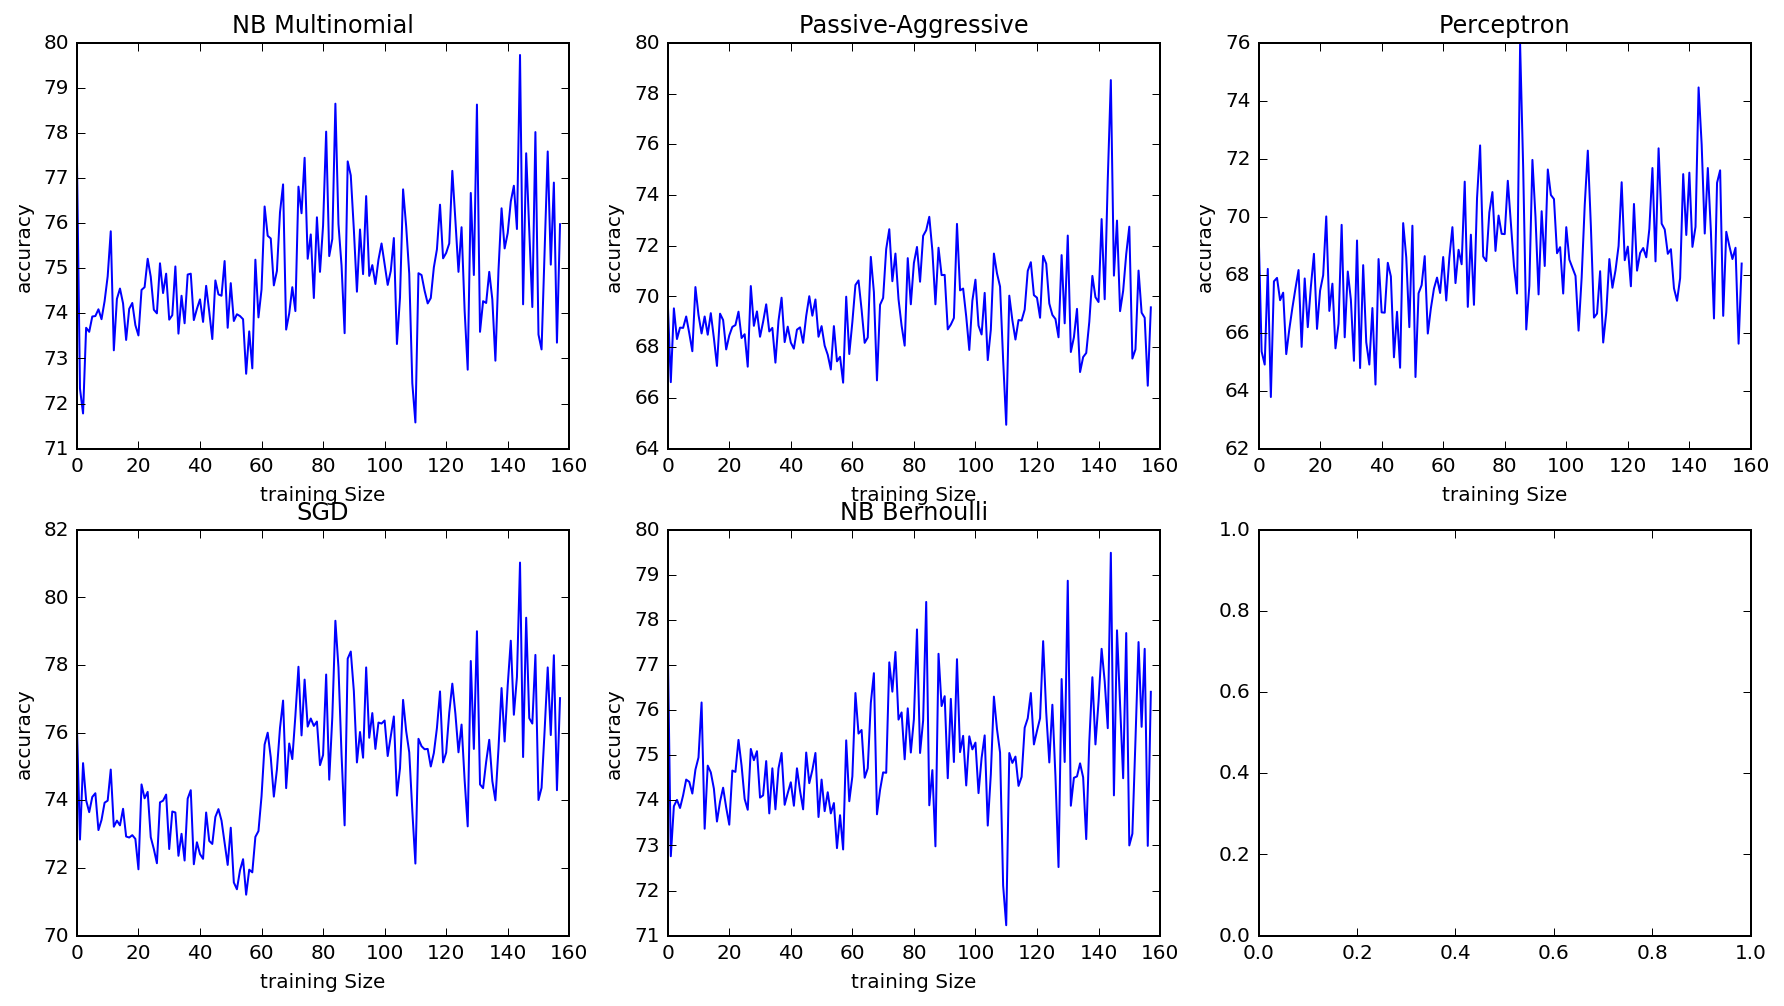

In [252]:
#print(classifier_information['SGD'])
#x = column(accuracy_info, 0)
#y = column(accuracy_info, 1)
#plt.plot(classifier_information['Preception'])
from sklearn.externals import joblib

joblib.dump(partial_fit_classifiers['SGD'], 'SGDClassifierOnSat.pkl')
joblib.dump(partial_fit_classifiers['Perceptron'], 'PerceptronClassifierOnSat.pkl')
joblib.dump(partial_fit_classifiers['NB Multinomial'], 'NBMClassifierOnSat.pkl')
joblib.dump(partial_fit_classifiers['Passive-Aggressive'], 'PAClassifierOnSat.pkl')
joblib.dump(partial_fit_classifiers['NB Bernoulli'], 'NBBClassifierOnSat.pkl')
i = 0
fig, axes = plt.subplots(2, 3, squeeze=True, figsize=(15, 8))
for item in classifier_information:
    axes[i//3,i%3].plot(classifier_information[item])
    axes[i//3,i%3].set_title(item)
    axes[i//3,i%3].set_ylabel("accuracy")
    axes[i//3,i%3].set_xlabel("training Size")
    i+=1


# Classifier For Amazon data 
** Feature extraction **

In [12]:
def compute_bag_of_words(text, stopwords, vocab=None):
    vectorizer = CountVectorizer(stop_words = stopwords,vocabulary=vocab)
    vectors = vectorizer.fit_transform(text)
    vocabulary = vectorizer.get_feature_names()
    return vectors, vocabulary

def column(matrix, i):
    return [row[i] for row in matrix]


text_amazon = column(Amazon_data,1)
Y_amazon = column(Amazon_data,0)


bow, vocab = compute_bag_of_words(text_amazon, stopwords.words())
KBestModel = SelectKBest( k=1000).fit(bow, Y_amazon) 
indices = KBestModel.get_support(True)
bow_transformed = KBestModel.transform(bow)
print("bow = {}".format(bow.shape))




NameError: name 'Amazon_data' is not defined

In [116]:
from sklearn.externals import joblib

best_features_Amazon = np.array(vocab)[indices]
#print(best_features_Amazon)

file = open('Best_Features_Amazon.txt', 'w')
for word in best_features_Amazon:
    file.write("%s\n" % word)    


In [13]:
#input X is list of strings
def Transform_To_Input_Format_Amazon(X):
    with open('Best_Features_Amazon.txt') as f:
        features = f.readlines()
    features = [x.strip("\n") for x in features]
    X_transformed,vocab = compute_bag_of_words(X, stopwords.words(),features)
    return X_transformed
    
print(Transform_To_Input_Format_Amazon(["I am having a wonderfull day","Thank you very much"]))

  (0, 226)	1
  (1, 558)	1


** Classifier **

We train 6 different classifiers on each of the datasets to compare the performance of each classifier:
K-NN
SVM
Random Forest Classifier
Ridge Classifier
Bernoulli Naive Bayes
Mutlinomial Naive Bayes


In [254]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB




batches = []
Ys=[]
Y_amazon = np.array(Y_amazon)
y_all = np.unique(np.asarray(column(Amazon_data,0)))
print(y_all)
minibatch_size = 10000
start=0
# divide data into batches
while(start < bow.shape[0]):
    if(start + minibatch_size < bow.shape[0]):
        batch = bow[start:start+minibatch_size]
        Ys.append(Y_amazon[start:start+minibatch_size])
        batches.append(batch)
        start+=minibatch_size
    else:
        batch = bow[start:]
        Ys.append(Y_amazon[start:])
        batches.append(batch)
        start+=minibatch_size
    i += 1

        
#Classifiers      
partial_fit_Regressors = {
    #'SGD Regressor':SGDRegressor(),
    #'Passive-Aggressive Regressor' : PassiveAggressiveRegressor(),
     'SGD': SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
        eta0=0.0, fit_intercept=True, l1_ratio=0,
        learning_rate='optimal', loss='hinge', n_iter=300, n_jobs=1,
        penalty='l2', power_t=0.5, random_state=None, shuffle=True,
        verbose=0, warm_start=False),
    'Perceptron': Perceptron(penalty='l1', alpha=0.0001, fit_intercept=True, n_iter=50, 
                             shuffle=True, verbose=0, eta0=1.0, n_jobs=1, random_state=0, 
                             class_weight=None, warm_start=False),
    'NB Multinomial': MultinomialNB(alpha=0.01),
    'Passive-Aggressive': PassiveAggressiveClassifier(),
    'NB Bernoulli': BernoulliNB(alpha=0.1),
    
}
Regressors_information = {
    #'SGD Regressor':[],
    #'Passive-Aggressive Regressor':[],
    'SGD':[],
    'Perceptron': [],
    'NB Multinomial': [],
    'Passive-Aggressive': [],
    'NB Bernoulli':[],
}   
                   
cls_stats = {}       
                  

number_minibatch = len(batches)
    
print(number_minibatch)
FirstBatch = True
k = 0
# Main loop : iterate on mini-batches of examples
for i in range(number_minibatch):
    print("Batch number = {}".format(i))
    batch = batches[i]
    X = batch
    Y = Ys[i]
    #classifiers
    for cls_name, cls in partial_fit_Regressors.items():
        tick = time.time()
        #cross_validation
        kf = KFold(n_splits = 10)
        results =[]
        for train_index,test_index in kf.split(X):
            X_train,X_test = X[train_index],X[test_index]
            Y_train,Y_test = Y[train_index],Y[test_index]
            if(FirstBatch and cls_name != "SGD Regressor" and cls_name != "Passive-Aggressive Regressor"):
                cls.partial_fit(X_train, Y_train, classes = y_all)
                train_pred = cls.predict(X_test)
                results.append(100*sklearn.metrics.accuracy_score(Y_test, train_pred))
            else:
                #Y_train = [int(x) for x in Y_train]
                #Y_test = [int(x) for x in Y_test]
                cls.partial_fit(X_train, Y_train)
                train_pred = cls.predict(X_test)
                results.append(100*sklearn.metrics.accuracy_score(Y_test, train_pred))
                #results.append(sklearn.metrics.mean_squared_error(Y_test, train_pred))
        Regressors_information[cls_name].append(np.mean(np.array(results)))
    FirstBatch = False

['1' '2' '3' '4' '5']
4
Batch number = 0
Batch number = 1
Batch number = 2
Batch number = 3


** Accuracy of Classifiers **


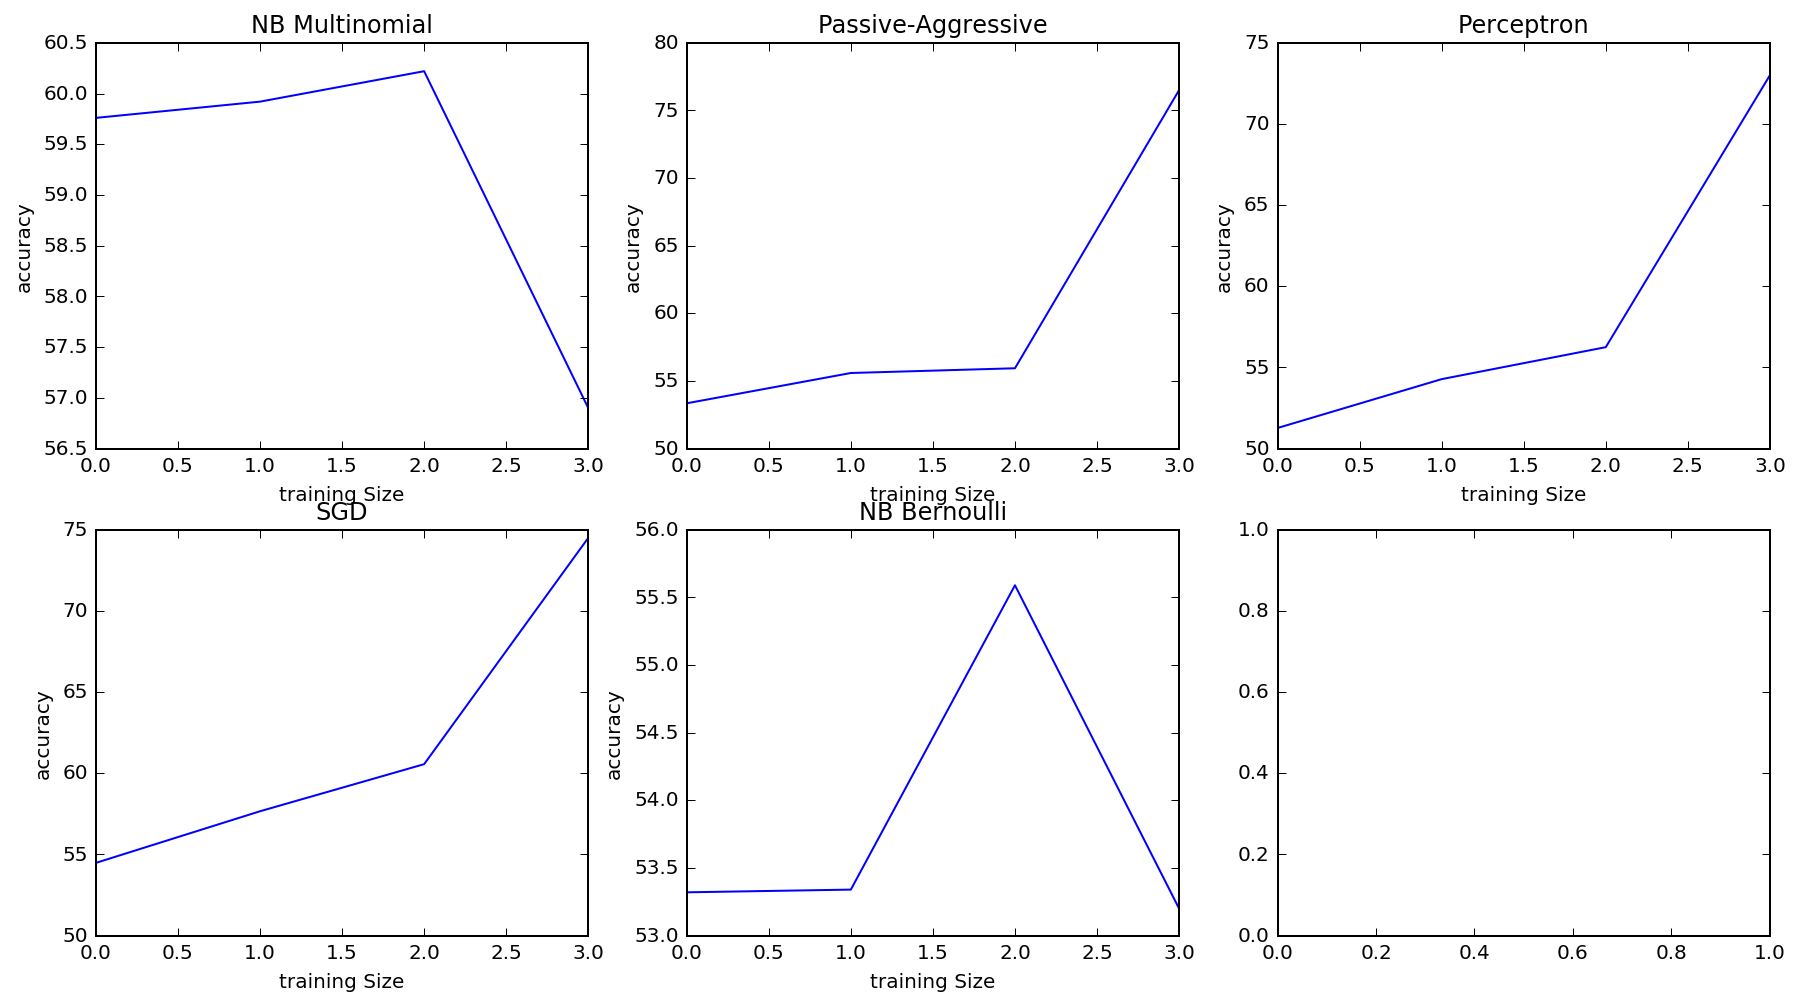

In [255]:
joblib.dump(partial_fit_Regressors['SGD'], 'SGDClassifierOnSat.pkl')
joblib.dump(partial_fit_Regressors['Perceptron'], 'PerceptronClassifierOnSat.pkl')
joblib.dump(partial_fit_Regressors['NB Multinomial'], 'NBMClassifierOnSat.pkl')
joblib.dump(partial_fit_Regressors['Passive-Aggressive'], 'PAClassifierOnSat.pkl')
joblib.dump(partial_fit_classifiers['NB Bernoulli'], 'NBBClassifierOnSat.pkl')


fig, axes = plt.subplots(2, 3, squeeze=True, figsize=(15, 8))
i = 0
for item in Regressors_information:
    axes[i//3,i%3].plot(Regressors_information[item])
    axes[i//3,i%3].set_title(item)
    axes[i//3,i%3].set_ylabel("accuracy")
    axes[i//3,i%3].set_xlabel("training Size")
    i+=1


## Datasets from Facebook and Twitter

Goal: collect comments from posts on Facebook and Twitter to evaluate the response of the audience (positive,negative).

## Facebook

In [8]:
import configparser

credentials = configparser.ConfigParser()
credentials.read('credentials.ini')
token = credentials.get('facebook', 'token')

import requests  
import facebook 
import pandas as pd
from IPython.display import display
import os

#testing with EPFL page, run it with the page of a politician's page
page = 'EPFL.ch'   #nb comments #nb likes #location  #comments likes 
postId= 10155100406682590

#prepare data
from datetime import datetime

def convert_time(row):
    return datetime.strptime(row, '%Y-%m-%dT%H:%M:%S+0000')

In [196]:
def getAllComments(postId,nb_comments_per_post,serie,fb):
    fields_comments = 'comment_count,like_count,created_time,message'
    url_comments = 'https://graph.facebook.com/{}/comments/?fields={}&access_token={}'.format(postId, fields_comments, token)
    
    comment =0
    #print(nb_comments_per_post)
    while comment <= nb_comments_per_post + 1:
    
        post_comments=requests.get(url_comments).json()
        
        
        #print('len ',len(post_comments['data']))
        i=0
        for com in post_comments['data']:
            i=i+1
           
            comment_message=com['message']
            serie['comment message'] = comment_message
            serie['comment time'] = com['created_time']
            serie['comment likes'] =  com['like_count']
            serie['comment id']=com['id']

            fb = fb.append(serie, ignore_index=True)
            comment=comment+1
        #print('i',i)
        #print(fb['comment message'])
        try:
            url_comments = post_comments['paging']['next']
        except KeyError:
            
            break
    
    return fb

        
    
    

In [251]:

def lastPostsReactions(page,filename,n):
    fields = 'id,created_time,message,likes.limit(0).summary(1),comments.limits(0).summary(1)'
    url = 'https://graph.facebook.com/{}/posts?fields={}&access_token={}'.format(page, fields, token)

    fb = pd.DataFrame(columns=['post message','post id','post time','post likes','nb of comments','comment id', 'comment message', 'comment time', 'comment likes'])# 'user name']) #'age', 'gender','location','political','religion','education'])
    serie={'post message':[],'post id':[],'post time':[],'post likes':[],'nb of comments':[],'comment id':[],'comment message':[],'comment time':[], 'comment likes':[]}#,'user name':[]} # 'age':[], 'gender':[],'location':[],'political':[],'religion':[],'education':[]};
    
    i=0
    while i < n: #len(fb) < n:
    
        posts = requests.get(url).json()
        
        # extract information for each of the received post
        for post in posts['data']:
           
            try:
                # Only work with posts with text.
                post_message = post['message']
                postId=post['id']
                try:
                    # Only work with posts with comments which have text.
                    nb_comments_per_post=post['comments']['summary']['total_count']
                
                    x= post['comments']['data'][0]['message'] #IndexError if no comment on the page, only work with posts
                    # which have at least 1 comment
                    i=i+1
    
                    post_message=post['message']
                    serie['post message']=post_message
                    serie['post time']=post['created_time']
                    serie['post likes']=post['likes']['summary']['total_count']
                    serie['nb of comments']= post['comments']['summary']['total_count']
                    serie['post id']=post['id']
                    
                    fb = getAllComments(post['id'],nb_comments_per_post,serie,fb)
                                                     
                except IndexError or KeyError:
                    continue 
            except KeyError:
                continue       
        try:
            url = posts['paging']['next']
            #print('next')
        except KeyError:
            #print('no next')
            break
            
    fb['comment message'] = fb['comment message'].astype(str)
    fb['post message'] = fb['post message'].astype(str)
    fb['comment likes']  = fb['comment likes'].astype(int)
    fb['post likes']  = fb['post likes'].astype(int)
    fb['nb of comments']  = fb['nb of comments'].astype(int)
    fb['post time'] = fb['post time'].apply(convert_time)
    fb['comment time'] = fb['comment time'].apply(convert_time)

    print("Number of posts: ",i)
    #display(fb[:])
    
    folder = os.path.join( 'data', 'social_media')
    try:
        os.makedirs(folder)
    except FileExistsError:
        pass

    filename = os.path.join(folder, 'facebook'+ filename +'.sqlite')
    fb.to_sql('facebook', 'sqlite:///' + filename, if_exists='replace')
        
                               
                               
    return fb


In [252]:
def postReactions (postId,postType,filename):
    #fields = 'id,created_time,message,likes.limit(0).summary(1),comments.limits(0).summary(1)'
    
    if postType==0:
        fields = 'id,updated_time,message,likes.limit(0).summary(1),comments.limits(0).summary(1)'
    else:
        fields = 'id,created_time,message,likes.limit(0).summary(1),comments.limits(0).summary(1)'
        
    url = 'https://graph.facebook.com/{}?fields={}&access_token={}'.format(postId, fields, token)

    fb = pd.DataFrame(columns=['post message','post id','post time','post likes','nb of comments','comment id', 'comment message', 'comment time', 'comment likes'])# 'user name']) #'age', 'gender','location','political','religion','education'])
    serie={'post message':[],'post id':[],'post time':[],'post likes':[],'nb of comments':[],'comment id':[],'comment message':[],'comment time':[], 'comment likes':[]}#,'user name':[]} # 'age':[], 'gender':[],'location':[],'political':[],'religion':[],'education':[]};
    
    post = requests.get(url).json()
    
    try:
        # Only work with posts with text.
        test = post['message']
        
        try:
            # Only work with posts with comments which have text.
            nb_comments_per_post=post['comments']['summary']['total_count']
            #print(nb_comments_per_post,' comments')
                
            x= post['comments']['data'][0]['message'] #IndexError if no comment on the page, only work with posts
            # which have at least 1 comment
            
            post_message=post['message']
            serie['post message']=post_message
            #serie['post time']=post['created_time']
            
            if postType==0:
                serie['post time']=post['updated_time']
            else:
                serie['post time']=post['created_time']
            
            serie['post likes']=post['likes']['summary']['total_count']
            serie['nb of comments']= post['comments']['summary']['total_count']
            serie['post id']=post['id']
        
            fb = getAllComments(postId,nb_comments_per_post,serie,fb)
                                     
        except IndexError or KeyError:
            print('')
    except KeyError:
        print('')

            
    fb['comment message'] = fb['comment message'].astype(str)
    fb['post message'] = fb['post message'].astype(str)
    fb['comment likes']  = fb['comment likes'].astype(int)
    fb['post likes']  = fb['post likes'].astype(int)
    fb['nb of comments']  = fb['nb of comments'].astype(int)
    fb['post time'] = fb['post time'].apply(convert_time)
    fb['comment time'] = fb['comment time'].apply(convert_time)
    
    #display(fb[:])
    
    folder = os.path.join( 'data', 'social_media')
    try:
        os.makedirs(folder)
    except FileExistsError:
        pass

    filename = os.path.join(folder, 'facebook'+ filename +'.sqlite')
    fb.to_sql('facebook', 'sqlite:///' + filename, if_exists='replace')

    
    return 


## Posts


In [ ]:
#test
#fb = lastPostsReactions(page,'EPFL',20)
#fb= postReactions(postId,'Monde')

#Donald Trump reaction to Meryl Streep speach
page = 'DonaldTrump'
postId= '10158439095420725'

fb= postReactions(postId,0,'DT1')

#Donald Trump speaks about a good relationship with Russia
page = 'DonaldTrump'
postId= '10158430269170725'

fb= postReactions(postId,0,'DT2')

#Donald Trump speaks about the defeat of the democrats
page = 'DonaldTrump'
postId= '10158423167515725'

fb= postReactions(postId,0,'DT3')

#Donald Trump speaks about Obamacare
page = 'DonaldTrump'
postId= '10158417912085725'

fb= postReactions(postId,0,'DT4')

In [2]:
#Donald Trump about winning more votes
page = 'DonaldTrump'
postId= '10158135498775725'

fb= postReactions(postId,0,'DT5')

#Hillary Clinton end year congratulations
page = 'hillaryclinton'
postId= '1376340812422444'

fb= postReactions(postId,0,'HC1')

#Hillary Clinton defeat speech
page = 'hillaryclinton'
postId= '1324421317614394'

fb= postReactions(postId,0,'HC2')

#Hillary Clinton asking for votes (before election)
page = 'hillaryclinton'
postId= '1322830897773436'

fb= postReactions(postId,1,'HC3')

#CNN article about orlando shooting's victims suing twitter and facebook
page = 'cnninternational'
postId= '10154812470324641'

fb= postReactions(postId,1,'CNN_OS1')

#CNN article about John McCain saying that Obama is responsible for the Orlando shooting
page = 'cnninternational'
postId= '10154219265779641'

fb= postReactions(postId,1,'CNN_OS2')

#CNN articles about gun sales after Orlando shooting
page = 'cnninternational'
postId= '10154210843679641'

fb= postReactions(postId,1,'CNN_OS3')

#CNN articles about Lena Dunham's aborption
page = 'cnninternational'
postId= '10154817313449641'

fb= postReactions(postId,1,'CNN_Ab1')

#CNN article about Texas fetus burial obliagtion
page = 'cnninternational'
postId= '10154738564069641'

fb= postReactions(postId,1,'CNN_Ab2')

#CNN article about pope abortion forgivness
page = 'cnninternational'
postId= '10154708071624641'

fb= postReactions(postId,1,'CNN_Ab3')

#David Cameron before brexit speaking about 
page = 'DavidCameronOfficial'
postId= '1216426805048302'

fb= postReactions(postId,1,'DC1')

#David Cameron before brexit speaking about 
page = 'DavidCameronOfficial'
postId= '1218229621534687'

fb= postReactions(postId,0,'DC2')

NameError: name 'token' is not defined

## Function to get predictions

In [560]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
from sklearn.externals import joblib

import sqlite3

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#function to get the SQLite file
def getTable(filename): #Example= 'facebookCNN_Ab1.sqlite'
    folder = os.path.join( 'data', 'social_media')
    filename = os.path.join(folder, filename)
    con = sqlite3.connect(filename)
    fb=pd.read_sql(('SELECT * FROM facebook'),con)
    return fb

#function to get the input of the classifier

def getInputComment(fb,ClassifierName):
    val=fb['comment message'].values.tolist()
    if(ClassifierName=='SAT'):
        new_val,f= Transform_To_Input_Format_SAT_Classifiers(val)
    if(ClassifierName=='Amazon'):
        new_val= Transform_To_Input_Format_Amazon(val)
    return new_val

def getInputPost(fb,ClassifierName):
    val=fb['post message'].values.tolist()
    if(ClassifierName=='SAT'):
        new_val,f= Transform_To_Input_Format_SAT_Classifiers(val)
    if(ClassifierName=='Amazon'):
        new_val= Transform_To_Input_Format_Amazon(val)
    return new_val

# function to get the prediction and add to 
def getAndAddPrediction(input_comment,input_post,fb,ClassifierName): # example ClassifierName='PAClassifierOnAmazon.pkl'
    prediction_comment=joblib.load(ClassifierName)
    sentiment_comment=prediction_comment.predict(input_comment)
    fb['comment sentiment']=sentiment_comment
    
    prediction_post=joblib.load(ClassifierName)
    sentiment_post=prediction_post.predict(input_post)
    fb['post sentiment']=sentiment_post
    return 
    



In [575]:
#test
#CNN article about pope abortion forgivness
page = 'cnninternational'
postId= '10154708071624641'

from IPython.display import display

#BINARY

#PAGE
#lastPostsReactions(postId,1,'CNN_page')
fb_page_b =getTable('facebookCNN_page.sqlite')
input_comment=getInputComment(fb_page_b,'SAT')
input_post=getInputPost(fb_page_b,'SAT')
getAndAddPrediction(input_comment, input_post,fb_page_b,'PAClassifierOnSAT.pkl')
display(fb_page_b[:])

#POST
#postReactions(postId,1,'CNN_Ab1')
fb_post_b =getTable('facebookDT3.sqlite')
input_comment=getInputComment(fb_post_b,'SAT')
input_post=getInputPost(fb_post_b,'SAT')
getAndAddPrediction(input_comment, input_post,fb_post_b,'PAClassifierOnSAT.pkl')
display(fb_post_b[:])

#AMAZON

#PAGE
#lastPostsReactions(postId,1,'CNN_page')
fb_page =getTable('facebookCNN_page.sqlite')
input_comment=getInputComment(fb_page,'Amazon')
input_post=getInputPost(fb_page,'Amazon')
getAndAddPrediction(input_comment, input_post,fb_page,'PAClassifierOnAmazon.pkl')
display(fb_page[:])

#POST
#postReactions(postId,1,'CNN_Ab1')
fb_post =getTable('facebookDT3.sqlite')
input_comment=getInputComment(fb_post,'Amazon')
input_post=getInputPost(fb_post,'Amazon')
getAndAddPrediction(input_comment, input_post,fb_post,'PAClassifierOnAmazon.pkl')
display(fb_post[:])



UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 6648: invalid continuation byte

## Data Analysis 

In [567]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

## Functions for a post analysis

In [573]:
import dateutil.parser as dateparser
import matplotlib

# Give the audience response to the post in function of the time of the comments
#Plot an histogram

def SentimentVSTimefForAPost(fb,sentiment_type,bins): #sentiment_type = 'binary' or 'five'
    c=['red','orange','yellow','greenyellow','green']
    c_b=['red','green']
    
    h=fb['comment time']
    mes=fb['comment message']
    pm=fb['post message']
    pm=pm[1]
    
    pt=fb['post time']
    pt=pt[1]
    
    postId=fb['post id']
    postId=postId[1]

    t=[]
    for item in h:
        t.append(dateparser.parse(item))

    #dates = matplotlib.dates.date2num(t)
    
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    plt.xlabel('Time')
    plt.ylabel('Number of comments')
    
    val0=[]
    val1=[]
    
    if(sentiment_type=='five'):
        val2=[]
        val3=[]
        val4=[]
        for i in range(0,len(fb)-1):
            if fb.ix[i]['comment sentiment']=='1':
                val0.append(t[i])
            if fb.ix[i]['comment sentiment']=='2':
                val1.append(t[i])
            if fb.ix[i]['comment sentiment']=='3':
                val2.append(t[i])
            if fb.ix[i]['comment sentiment']=='4':
                val3.append(t[i])
            if fb.ix[i]['comment sentiment']=='5':
                val4.append(t[i])


    
        ax.hist([matplotlib.dates.date2num(val0),matplotlib.dates.date2num(val1),matplotlib.dates.date2num(val2),matplotlib.dates.date2num(val3),matplotlib.dates.date2num(val4)],log=True,color=c,label=['1=negative','2','3','4','5=positive'],bins=bins)
        
    if(sentiment_type=='binary'):
        for i in range(0,len(fb)-1):
            if fb.ix[i]['comment sentiment']=='0':
                val0.append(t[i])
            if fb.ix[i]['comment sentiment']=='1':
                val1.append(t[i])  
        ax.hist([matplotlib.dates.date2num(val0),matplotlib.dates.date2num(val1)],color=c_b,label=['0=negative','1=positive'], bins=bins)


    #draw a red line at the time of the post
    matplotlib.pyplot.axvline(x=matplotlib.dates.date2num(dateparser.parse(pt)),color='blue')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    locator = matplotlib.dates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(matplotlib.dates.AutoDateFormatter(locator))
    fig.autofmt_xdate()
    matplotlib.pyplot.title(postId)
    plt.show()
    

    return

# Give the correspondance between likes and the sentiment value of the comments
#plot number of comments VS numbers of likes on the comment with the sentimal value as a parameter 
def SentimentVSCommentsLikes(fb, sentiment_type):
    c=['red','orange','yellow','greenyellow','green']
    c_b=['red','green']
    likes=fb['comment likes']
    
    postId=fb['post id']
    postId=postId[1]
    
    fig, ax = plt.subplots(1,1,figsize=(20,10))
   
    likes0=[]
    likes1=[]
    
    if(sentiment_type=='five'):
        likes2=[]
        likes3=[]
        likes4=[]
        for i in range(0,len(fb)-1):
            if fb.ix[i]['comment sentiment']=='1':
                likes0.append(likes[i])
            if fb.ix[i]['comment sentiment']=='2':
                likes1.append(likes[i])
            if fb.ix[i]['comment sentiment']=='3':
                likes2.append(likes[i])
            if fb.ix[i]['comment sentiment']=='4':
                likes3.append(likes[i])
            if fb.ix[i]['comment sentiment']=='5':
                likes4.append(likes[i])

        ax.hist([likes0,likes1,likes2,likes3,likes4],log=True,color=c,label=['1=negative','2','3','4','5=positive'],bins=[-0.5,0.5,2.5,6.5,14.5,30.5,62.5,126.5,254.5,510.5,1022.5])
   
    if(sentiment_type=='binary'):
        for i in range(0,len(fb)-1):
            if fb.ix[i]['comment sentiment']=='0':
                likes0.append(likes[i])
            if fb.ix[i]['comment sentiment']=='1':
                likes1.append(likes[i])
                
        ax.hist([likes0,likes1],color=c_b,label=['0=negative','1=positive'],bins=10)

    plt.xlim((-0.5,max(likes)))
    
    plt.xlabel('Number of likes')
    plt.ylabel('Number of comments')
    matplotlib.pyplot.title(postId)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()
    return

# function for :  Sentiment evaluation over all comments of a post  (not in fucntion of the time)
def ReactionToAPost(fb,sentiment_type):
    c=['red','orange','yellow','greenyellow','green']
    c_b=['red','green']
    mes=fb['comment message']
    pm=fb['post message']
    pm=pm[1]

    
    postId=fb['post id']
    postId=postId[1]


    
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    plt.xlabel('Sentiment Value')
    plt.ylabel('Number of comments')
    
    val0=[]
    val1=[]
    
    if(sentiment_type=='five'):
        val2=[]
        val3=[]
        val4=[]
        val5=[]
        for i in range(0,len(fb)-1):
            if fb.ix[i]['comment sentiment']=='1':
                val1.append(1)
            if fb.ix[i]['comment sentiment']=='2':
                val2.append(2)
            if fb.ix[i]['comment sentiment']=='3':
                val3.append(3)
            if fb.ix[i]['comment sentiment']=='4':
                val4.append(4)
            if fb.ix[i]['comment sentiment']=='5':
                val5.append(5)
            
        
        ax.hist([val1,val2,val3,val4,val5],color=c,label=['1=negative','2','3','4','5=positive'],bins=5) #range(1,5,1))
        
    if(sentiment_type=='binary'):
        for i in range(0,len(fb)-1):
            if fb.ix[i]['comment sentiment']=='0':
                val0.append(0)
            if fb.ix[i]['comment sentiment']=='1':
                val1.append(1) 
                
        ax.hist([val0,val1],color=c_b,label=['0=negative','1=positive'], bins=2)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    matplotlib.pyplot.title(postId)
    
    plt.show()
    
    return


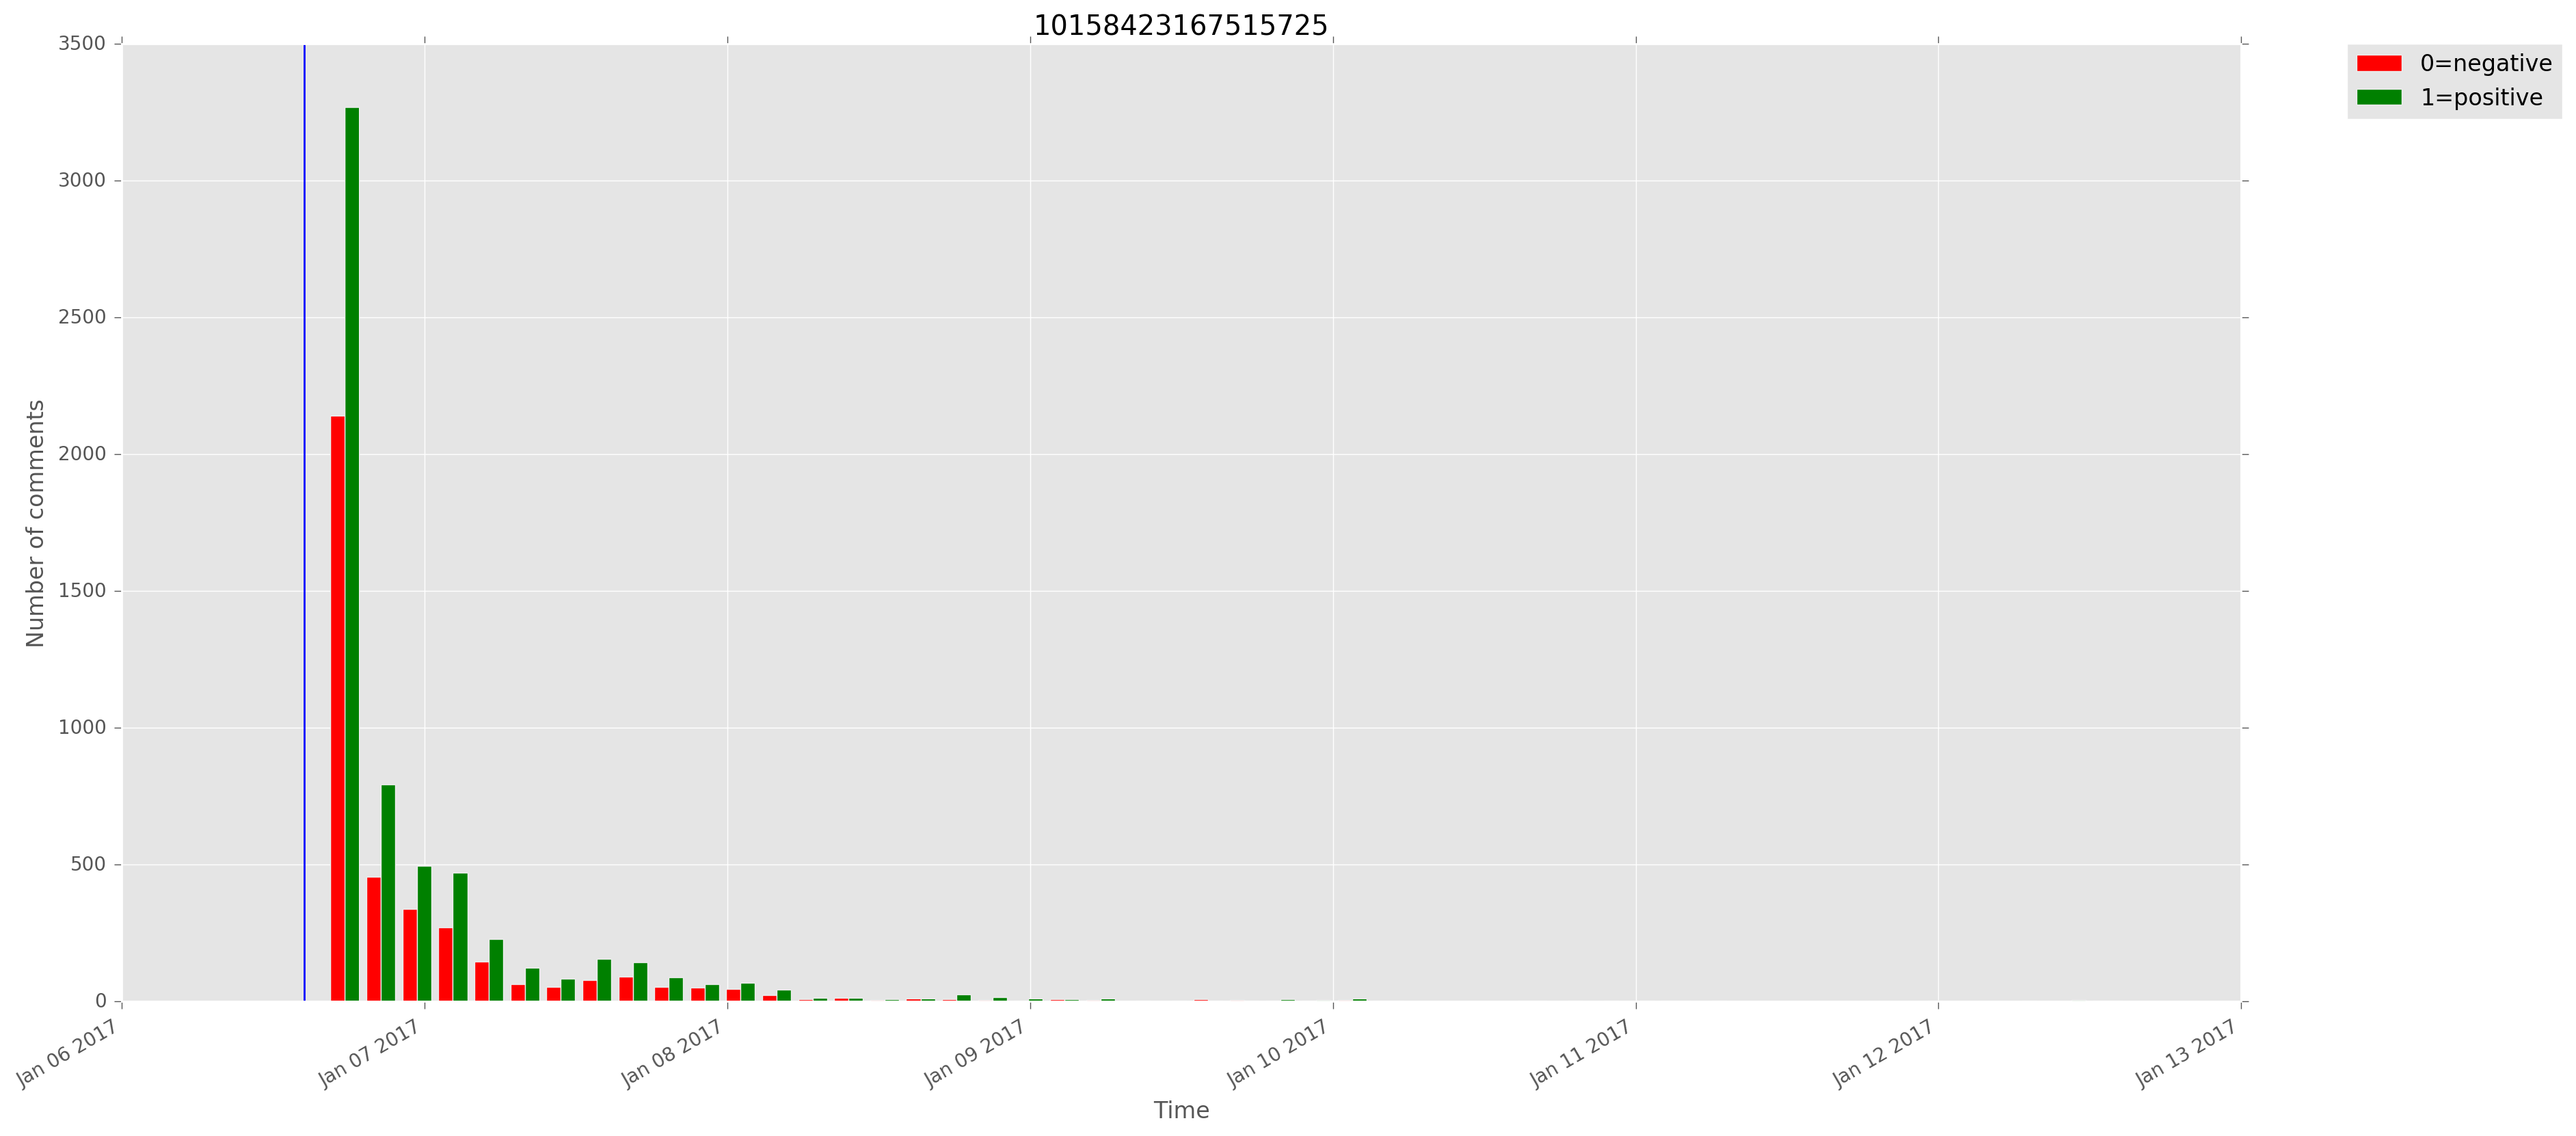

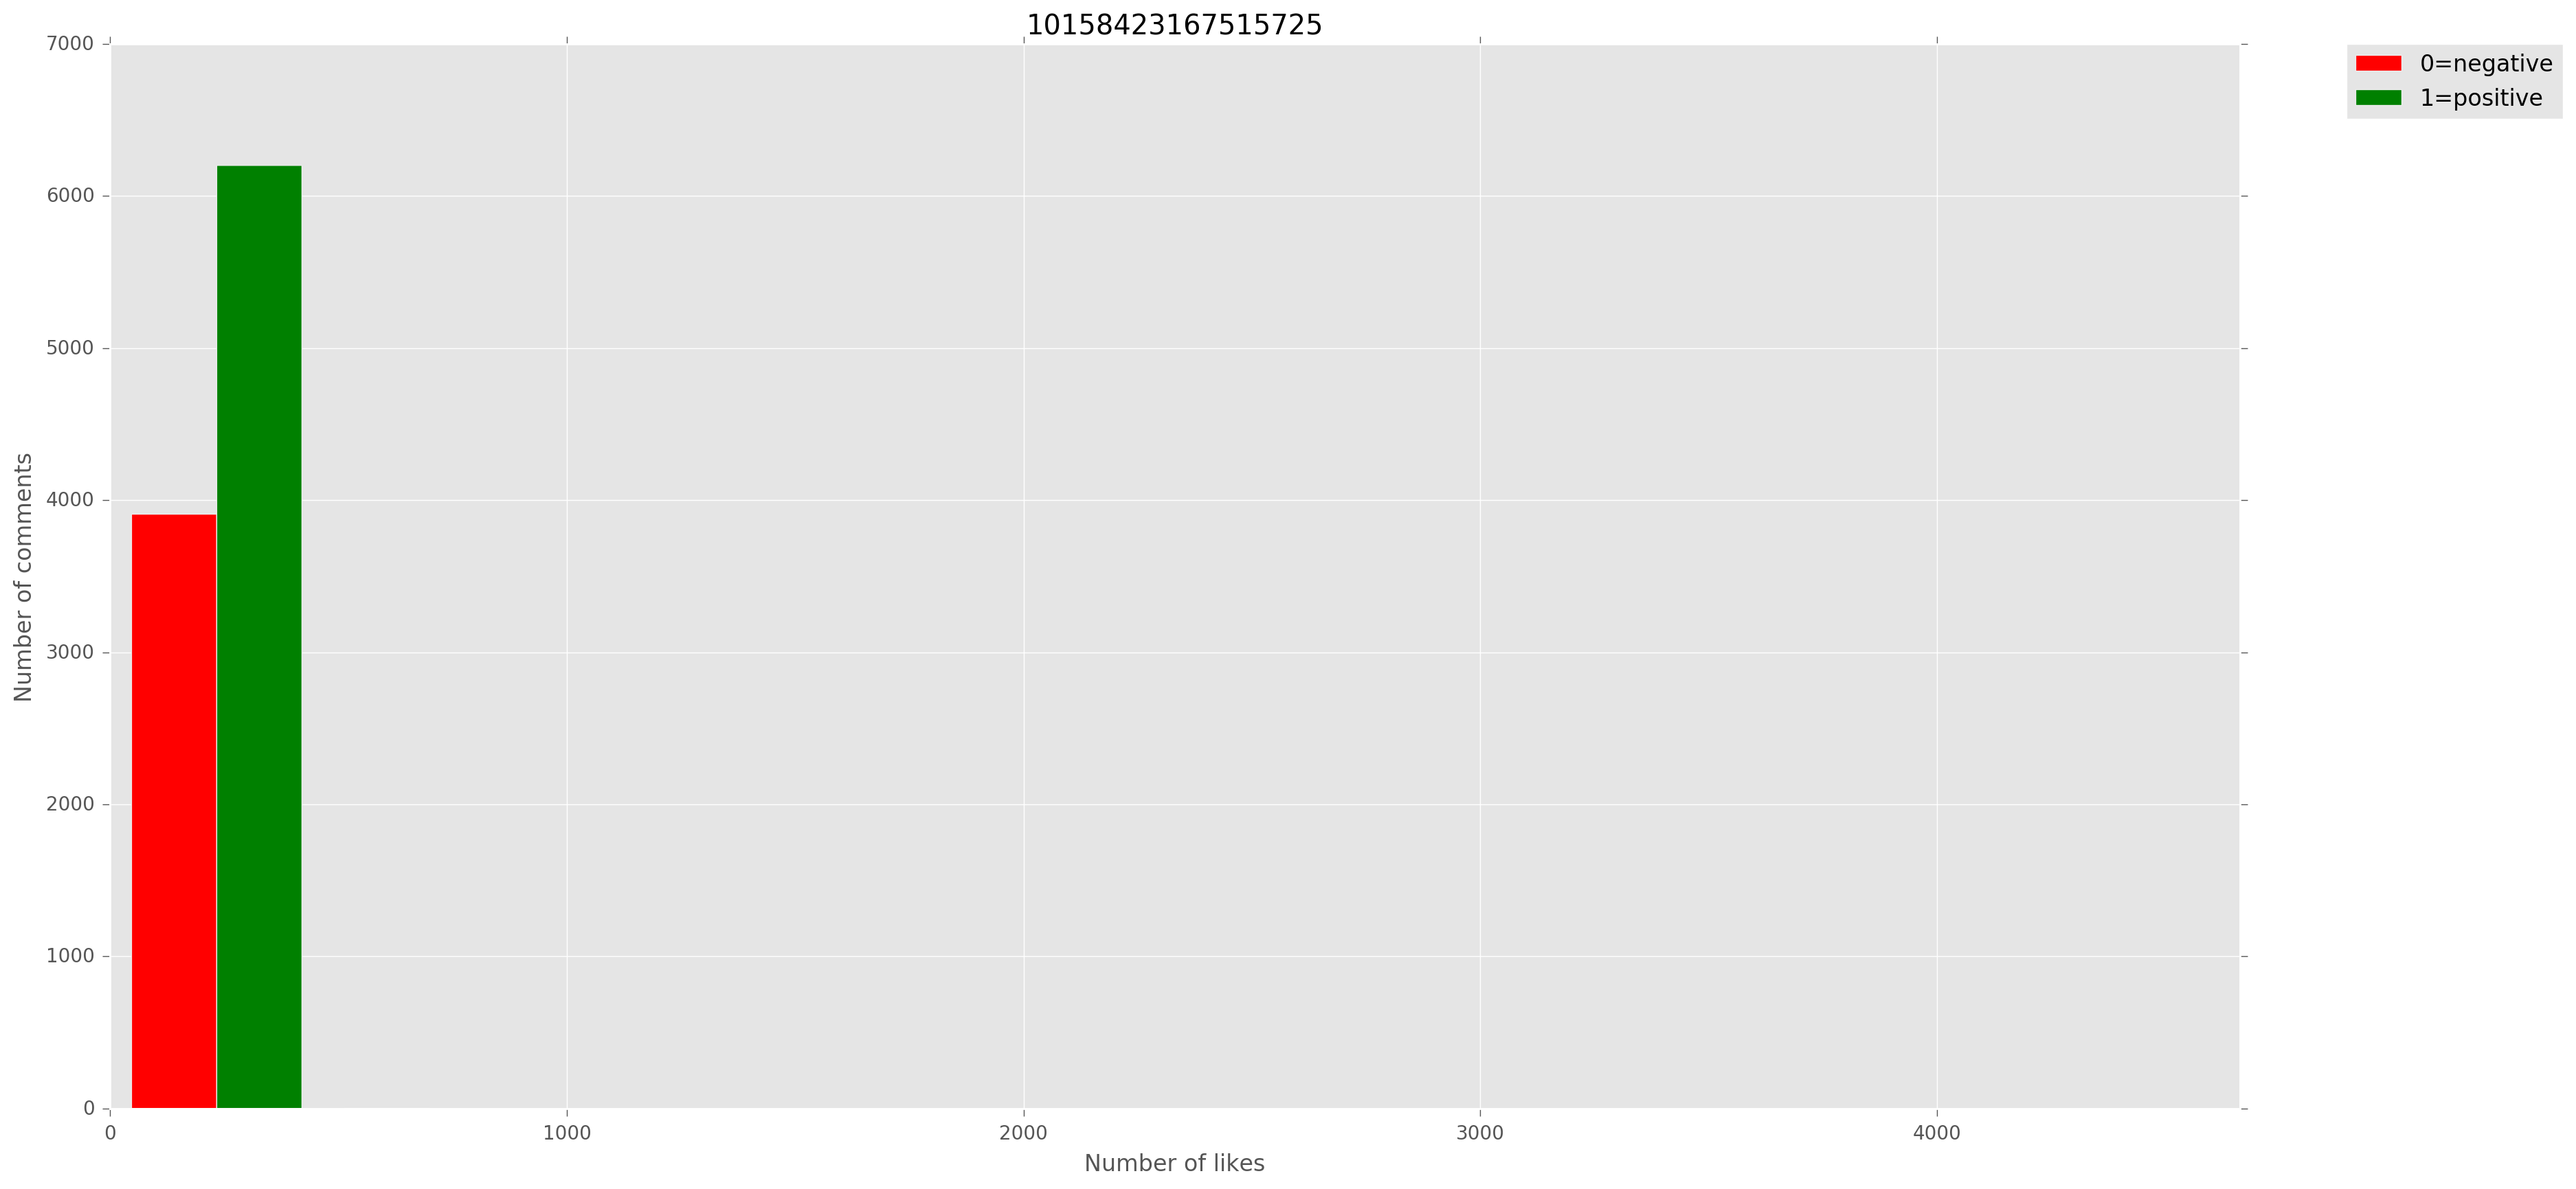

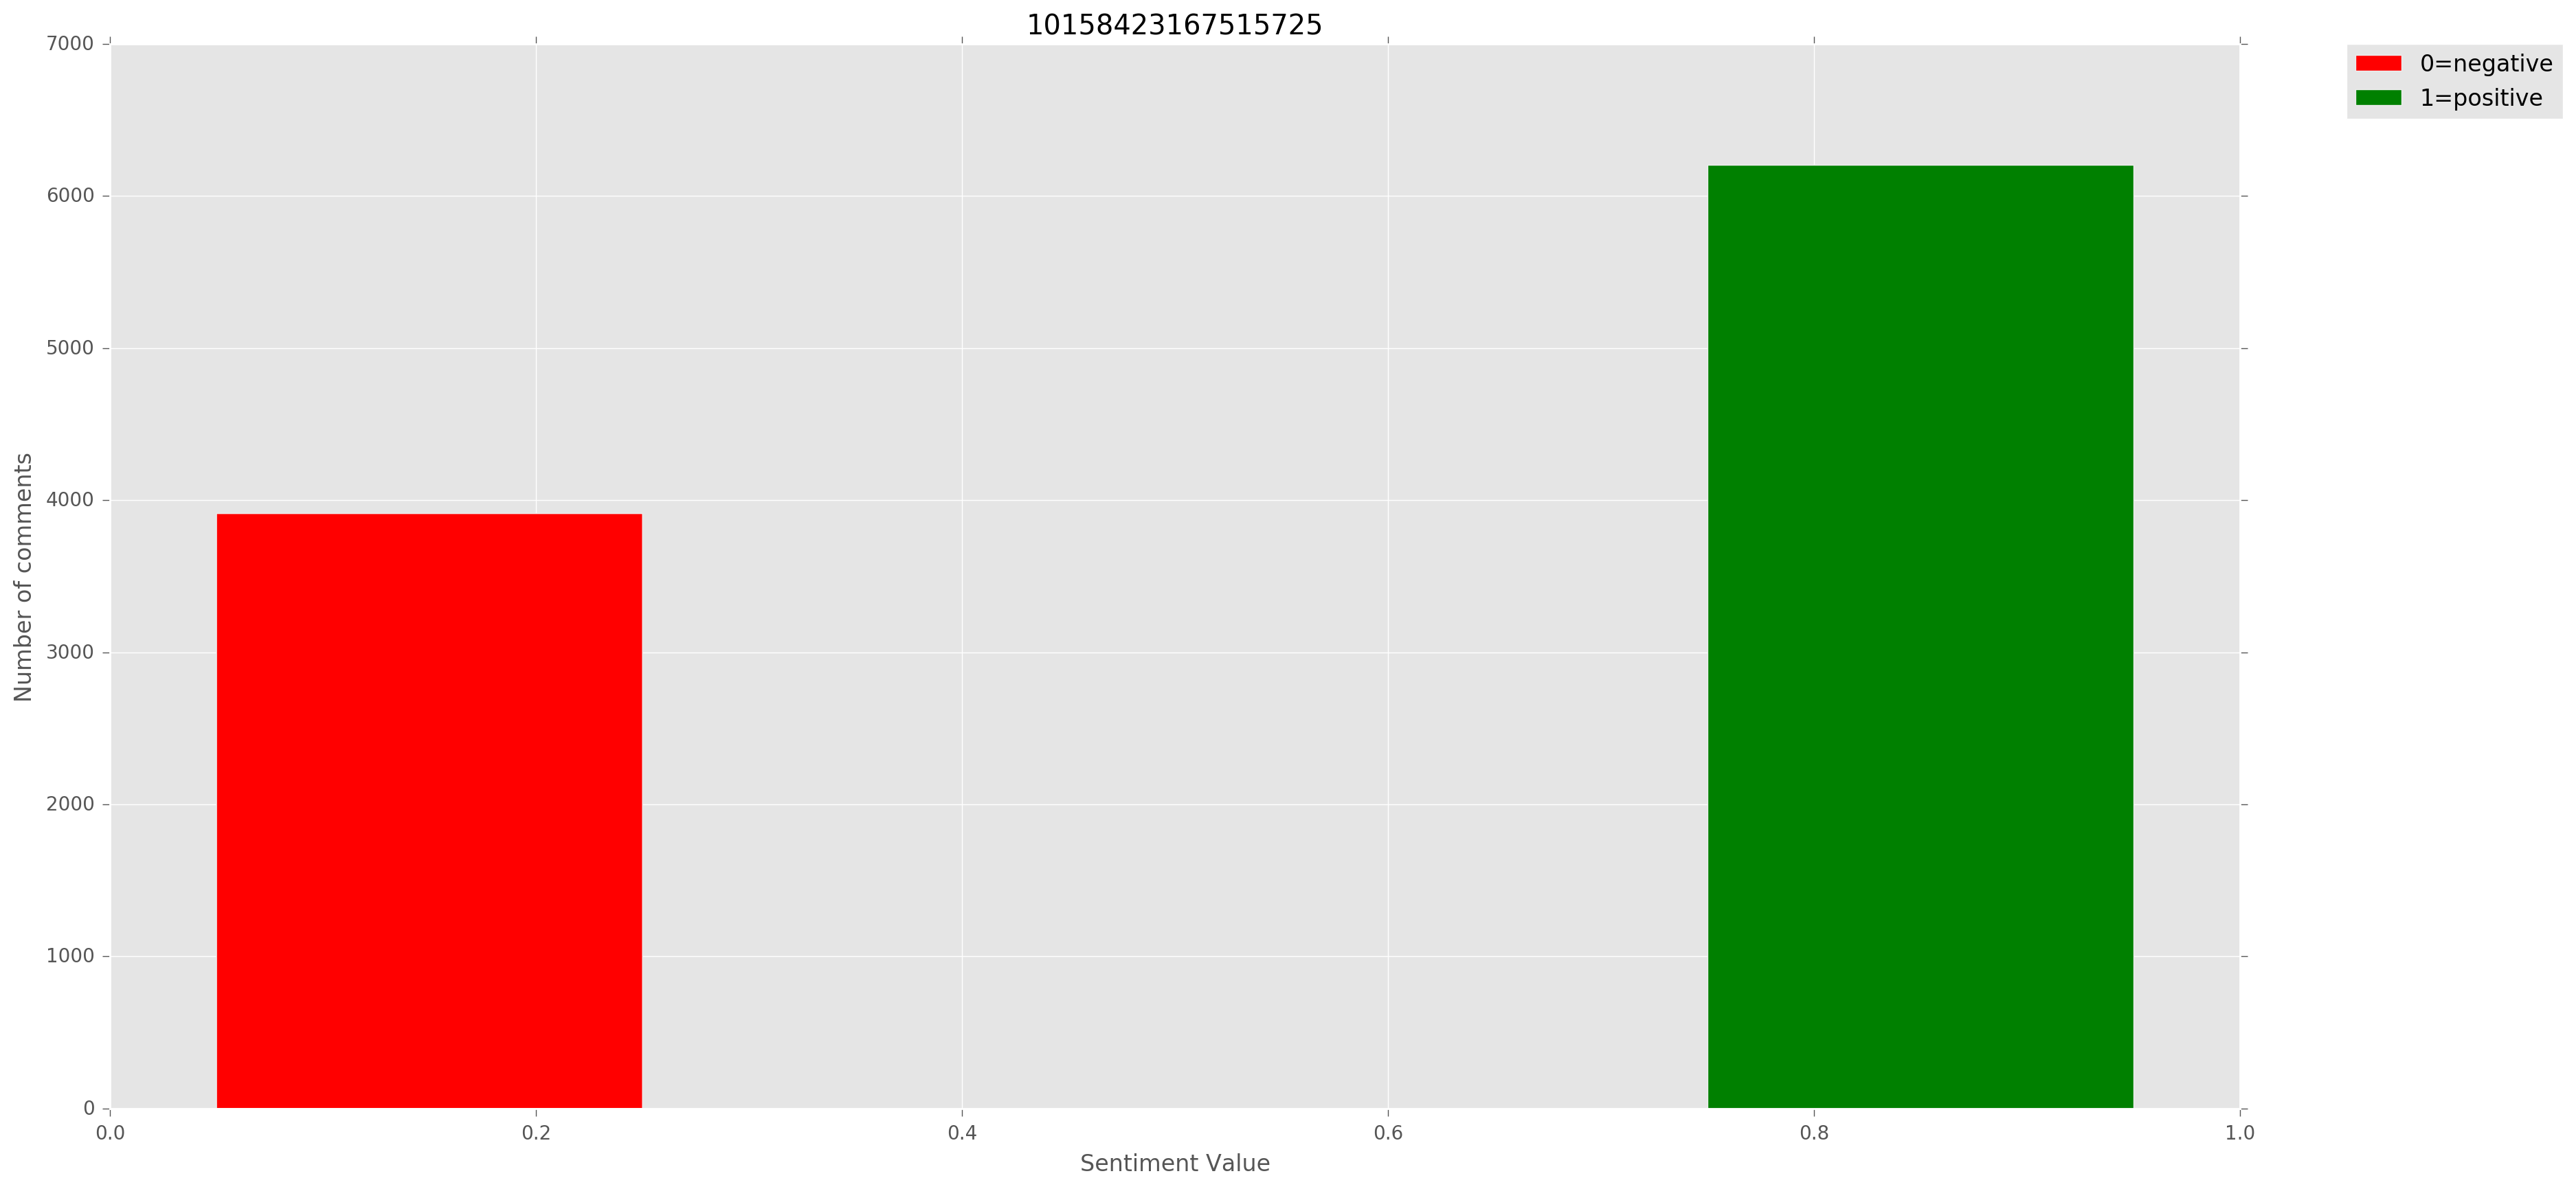

Post sentiment:  5


In [574]:
#test BINARY 
SentimentVSTimefForAPost(fb_post_b,'binary',50)
SentimentVSCommentsLikes(fb_post_b,'binary')
ReactionToAPost(fb_post_b,'binary')
post_sentiment=fb_post_b['post sentiment']
post_sentiment=post_sentiment[1]
print("Post sentiment: ", post_sentiment)

#test Amazon
SentimentVSTimefForAPost(fb_post,'five',50)
SentimentVSCommentsLikes(fb_post,'five')
ReactionToAPost(fb_post,'five')
post_sentiment=fb_post['post sentiment']
post_sentiment=post_sentiment[1]
print("Post sentiment: ", post_sentiment)



## Functions for a page analysis

In [500]:
## Functions for  a page analysis

# function for :Look the audience response to the posts in function of the time of the post. 
    
# look at the general audience response on the page.

# function for :If positive post , more likes ? more comments ? more positives/negatives comments ?. (also histogramme)
def PostsSentimentVSPostsLikes(fb,sentiment_type):
    c=['red','orange','yellow','greenyellow','green']
    c_b=['red','green']
    likes=fb['post likes']
    
    fig, ax = plt.subplots(1,1,figsize=(20,10))

    likes1=[]

    if(sentiment_type=='five'):
        likes2=[]
        likes3=[]
        likes4=[]
        likes5=[]
        i=0
        x = True
        newPostId=''
        while(x) :
            lastPostId=newPostId
            newPostId=fb.ix[i]['post id']
                
            if fb.ix[i]['post sentiment']=='1':
                if(lastPostId != newPostId):
                    likes1.append(likes[i])
                i = i + 1
            if fb.ix[i]['post sentiment']=='2':
                if(lastPostId != newPostId):
                    likes2.append(likes[i])
                i = i + 1
            if fb.ix[i]['post sentiment']=='3':
                if(lastPostId != newPostId):
                    likes3.append(likes[i])
                i = i + 1
            if fb.ix[i]['post sentiment']=='4':
                if(lastPostId != newPostId):
                    likes4.append(likes[i])
                i = i + 1 
            if fb.ix[i]['post sentiment']=='5':
                if(lastPostId != newPostId):
                    likes5.append(likes[i])
                i = i + 1
            if i == len(fb)-1:
                x=False
        
        ax.hist([likes1,likes2,likes3,likes4,likes5],color=c,label=['1=negative','2','3','4','5=positive'],histtype='barstacked')
   
    if(sentiment_type=='binary'):
        x=True
        i=0
        newPostId=''
        while x:
            lastPostId=newPostId
            newPostId=fb.ix[i]['post id']
            if fb.ix[i]['post sentiment']=='0':
                if(lastPostId != newPostId):
                    likes0.append(likes[i])
                i = i + 1
            if fb.ix[i]['post sentiment']=='1':
                if(lastPostId != newPostId):
                    likes1.append(likes[i])
                i = i + 1
            if i == len(fb)-1:
                x=False
                
        ax.hist([likes0,likes1],color=c_b,label=['0=negative','1=positive'])


    
    plt.xlabel('Number of likes')
    plt.ylabel('Number of posts')
    matplotlib.pyplot.title('Posts sentiment VS Posts likes')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()
    return

def PostsSentimentsVSCommentsCount(fb,sentiment_type):
    c=['red','orange','yellow','greenyellow','green']
    c_b=['red','green']
    count=fb['nb of comments']
    
    fig, ax = plt.subplots(1,1,figsize=(20,10))
   
    count0=[]
    count1=[]

    if(sentiment_type=='five'):
        count2=[]
        count3=[]
        count4=[]
        count5=[]
        
        i=0
        x = True
        newPostId=''
        while(x) :
            lastPostId=newPostId
            newPostId=fb.ix[i]['post id']
                
            if fb.ix[i]['post sentiment']=='1':
                if(lastPostId != newPostId):
                    count1.append(count[i])
                i = i + 1
            if fb.ix[i]['post sentiment']=='2':
                if(lastPostId != newPostId):
                    count2.append(count[i])
                i = i + 1
            if fb.ix[i]['post sentiment']=='3':
                if(lastPostId != newPostId):
                    count3.append(count[i])
                i = i + 1
            if fb.ix[i]['post sentiment']=='4':
                if(lastPostId != newPostId):
                    count4.append(count[i])
                i = i + 1 
            if fb.ix[i]['post sentiment']=='5':
                if(lastPostId != newPostId):
                    count5.append(count[i])
                i = i + 1
            if i == len(fb)-1:
                x=False
        #print(count0,count1,count2,count3,count4,count5)
        #print(len(count0)+len(count1)+len(count2)+len(count3)+len(count4)+len(count5))
        ax.hist([count1,count2,count3,count4,count5],color=c,label=['1=negative','2','3','4','5=positive'])
   
    if(sentiment_type=='binary'):
        x=True
        i=0
        newPostId=''
        while x:
            lastPostId=newPostId
            newPostId=fb.ix[i]['post id']
            if fb.ix[i]['post sentiment']=='0':
                if(lastPostId != newPostId):
                    count0.append(count[i])
                i = i + 1
            if fb.ix[i]['post sentiment']=='1':
                if(lastPostId != newPostId):
                    count1.append(count[i])
                i = i + 1
            if i == len(fb)-1:
                x=False
                
        ax.hist([count0,count1],color=c_b,label=['0=negative','1=positive'])


    
    plt.xlabel('Number of comments')
    plt.ylabel('Number of posts')
    matplotlib.pyplot.title('Post sentiment VS Numbers of comments ')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    plt.show()
    return
    


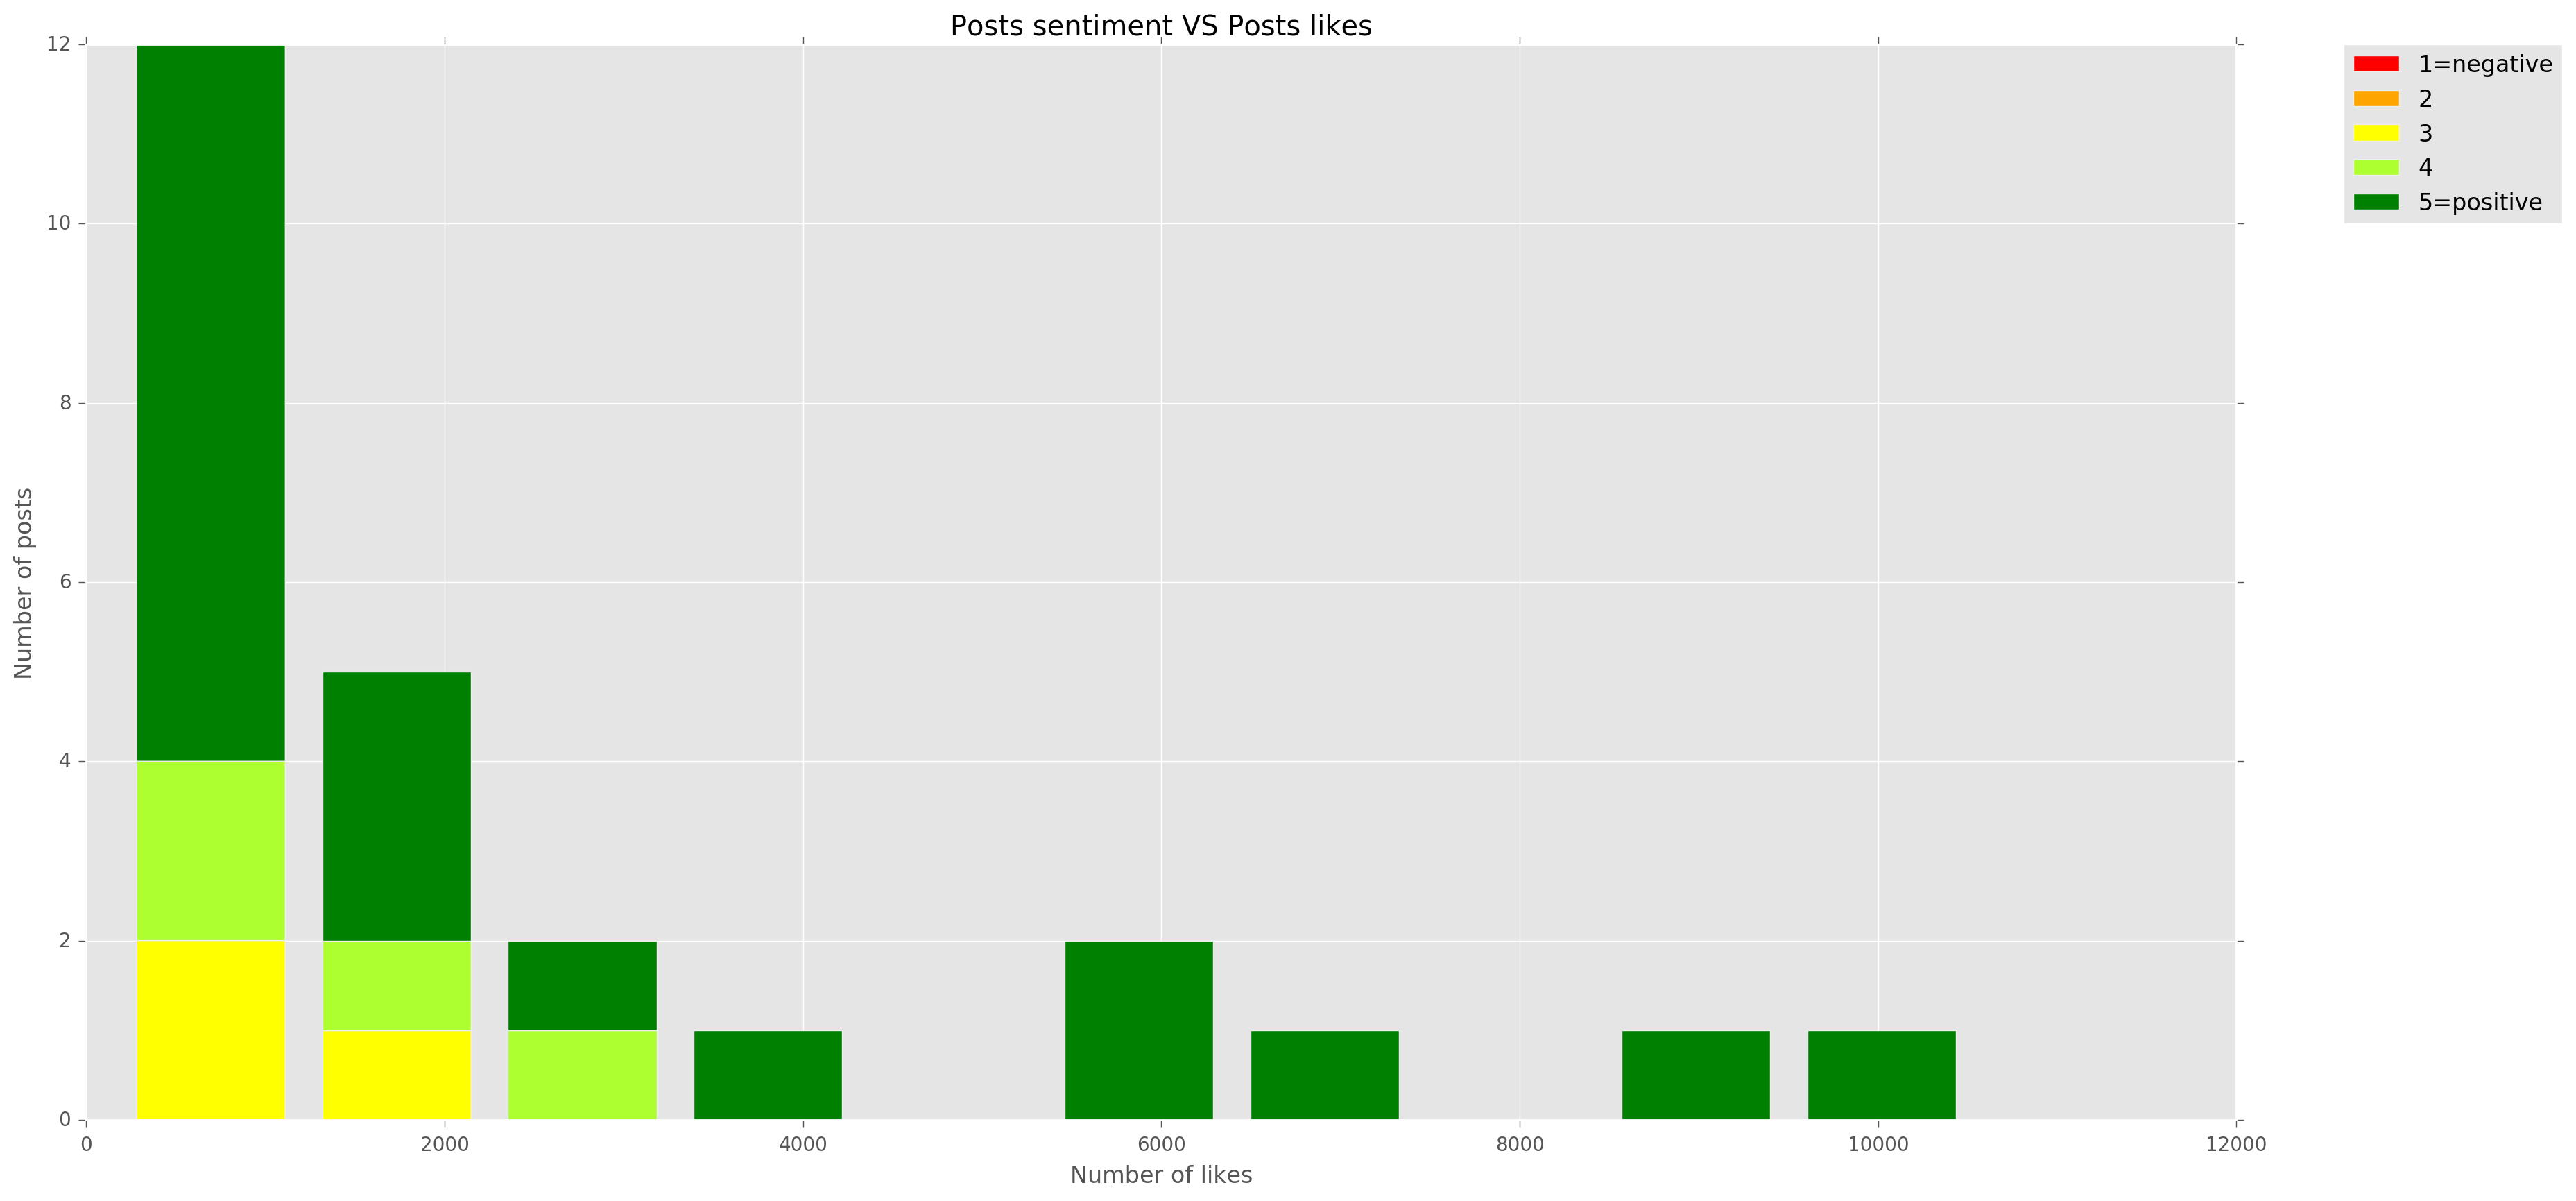

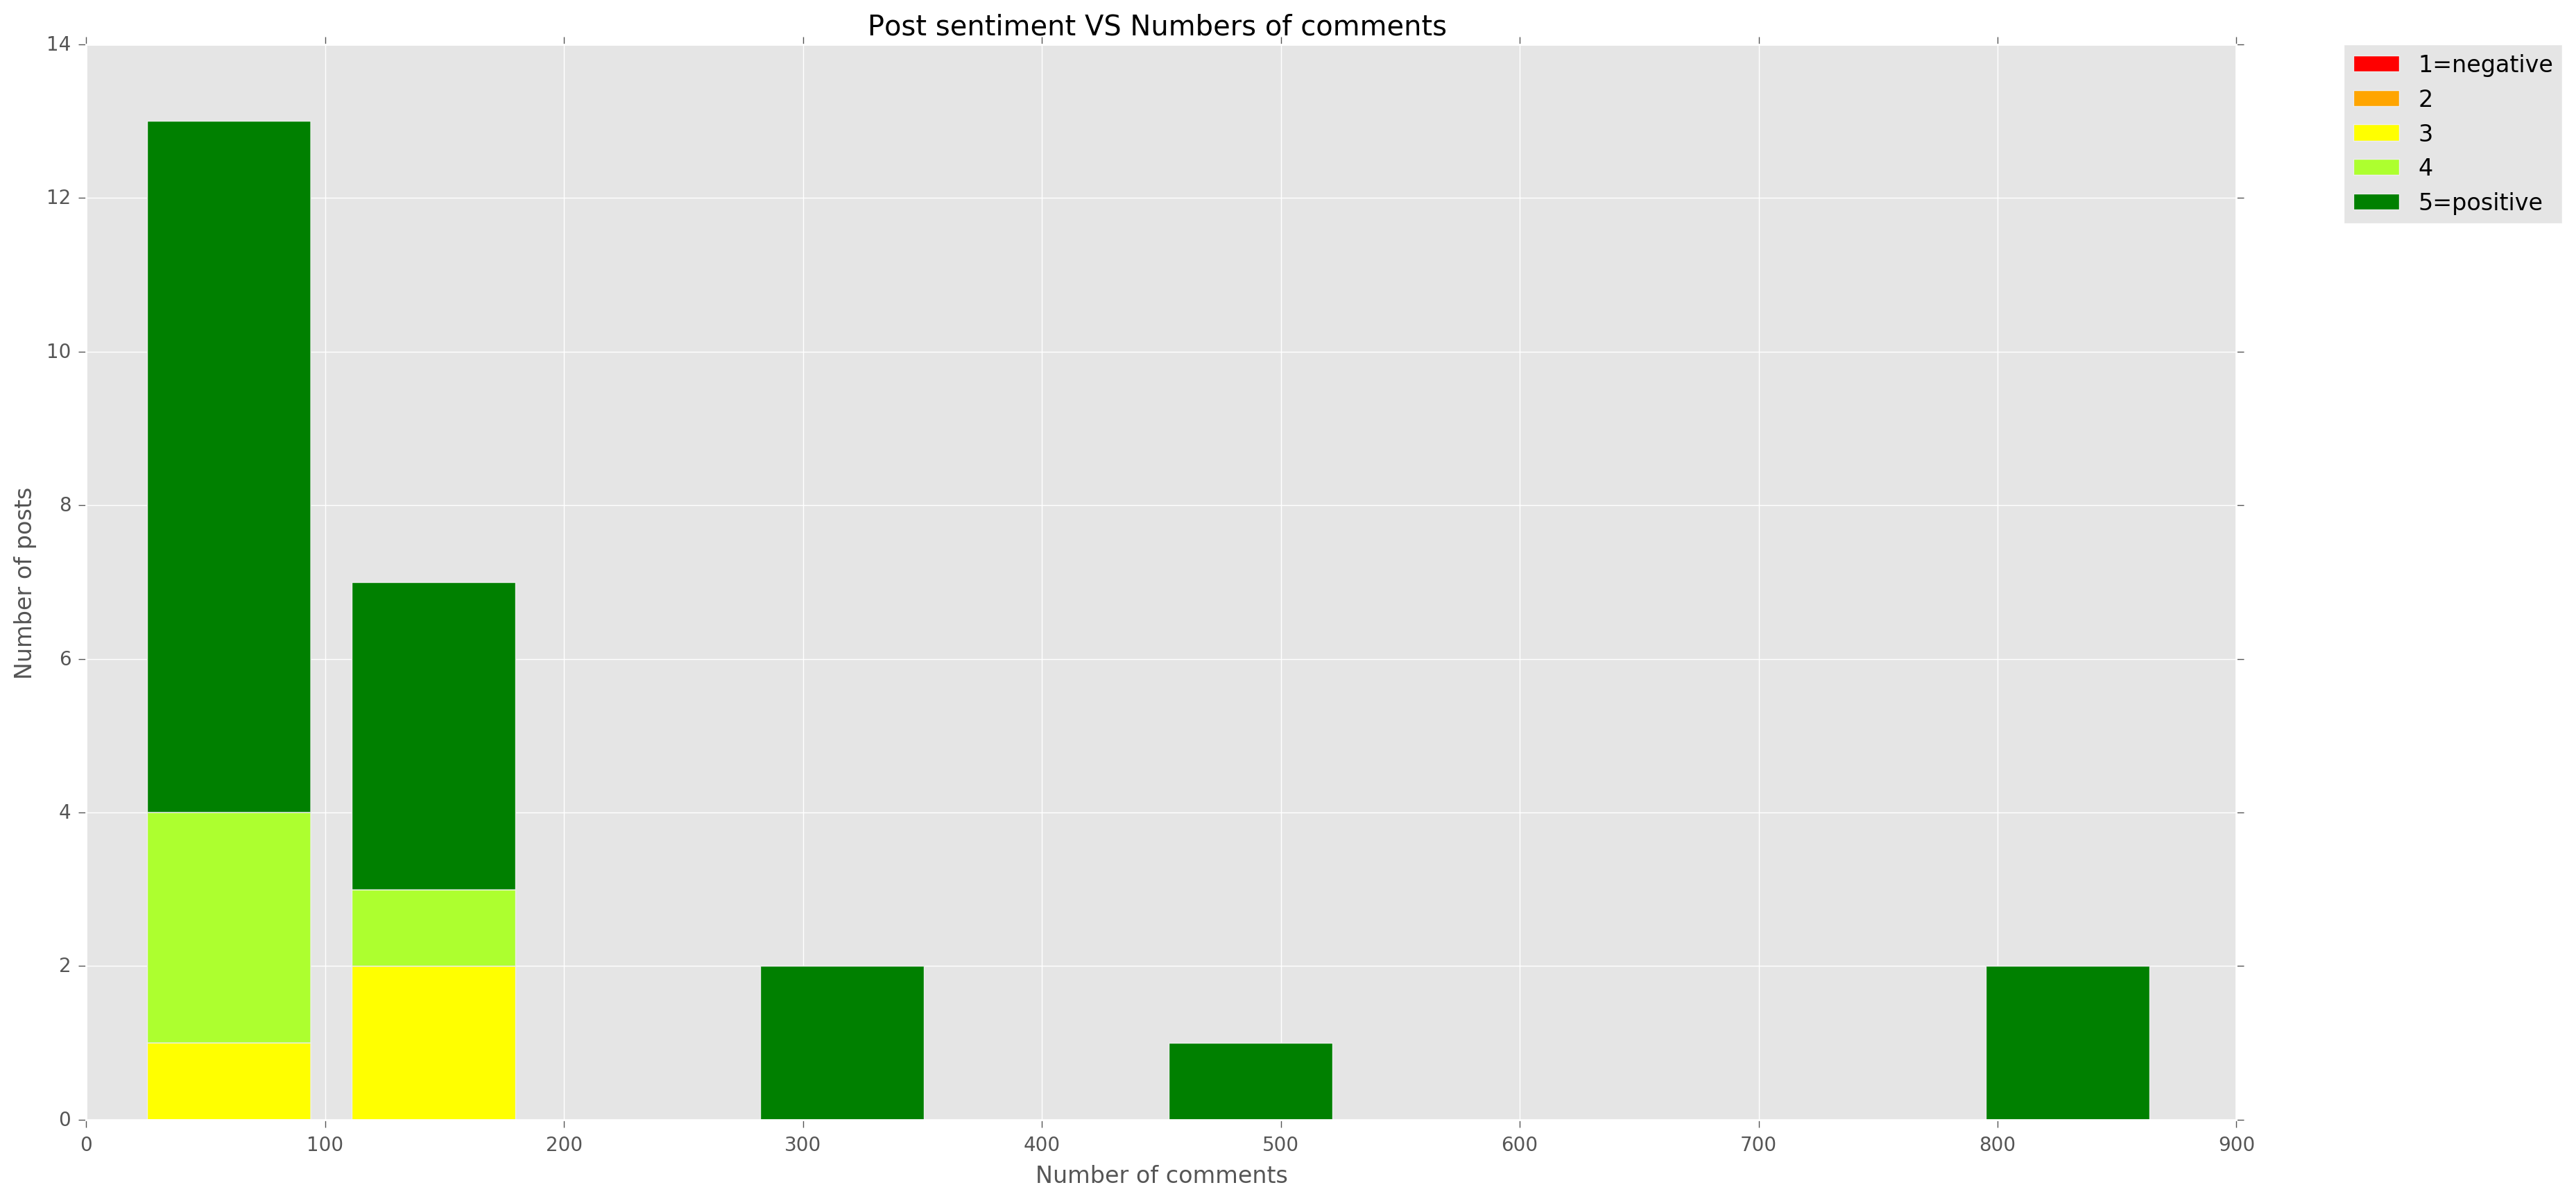

In [501]:
#test
PostsSentimentVSPostsLikes(fb_page,'five')
PostsSentimentsVSCommentsCount(fb_page,'five')

## Samuel's code

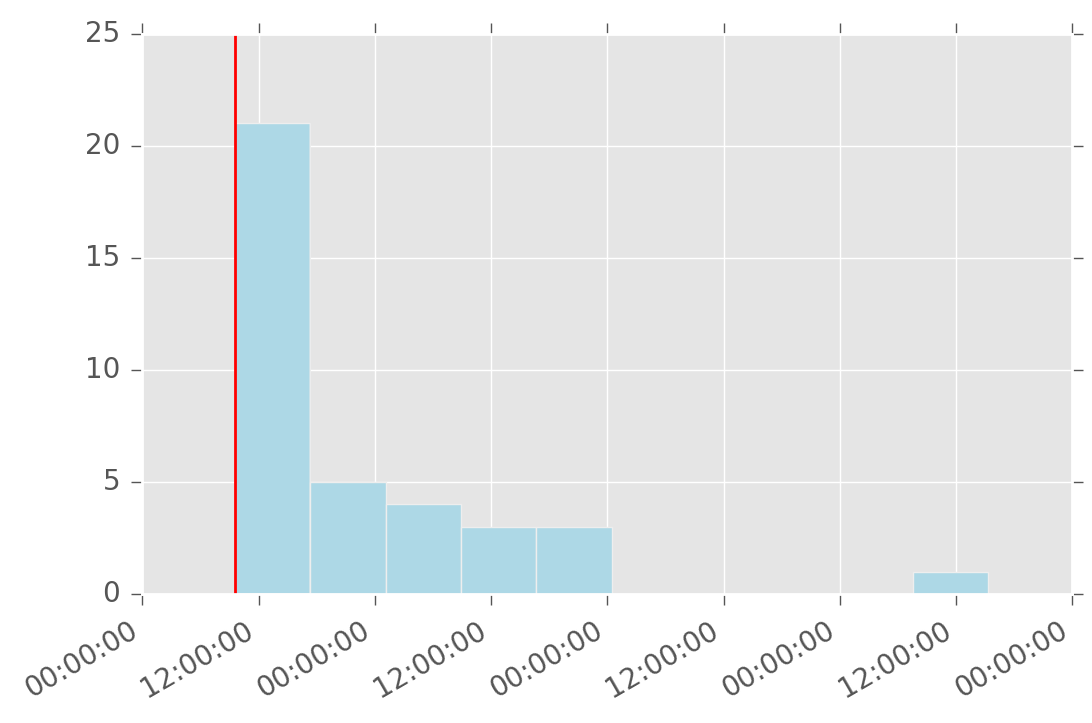

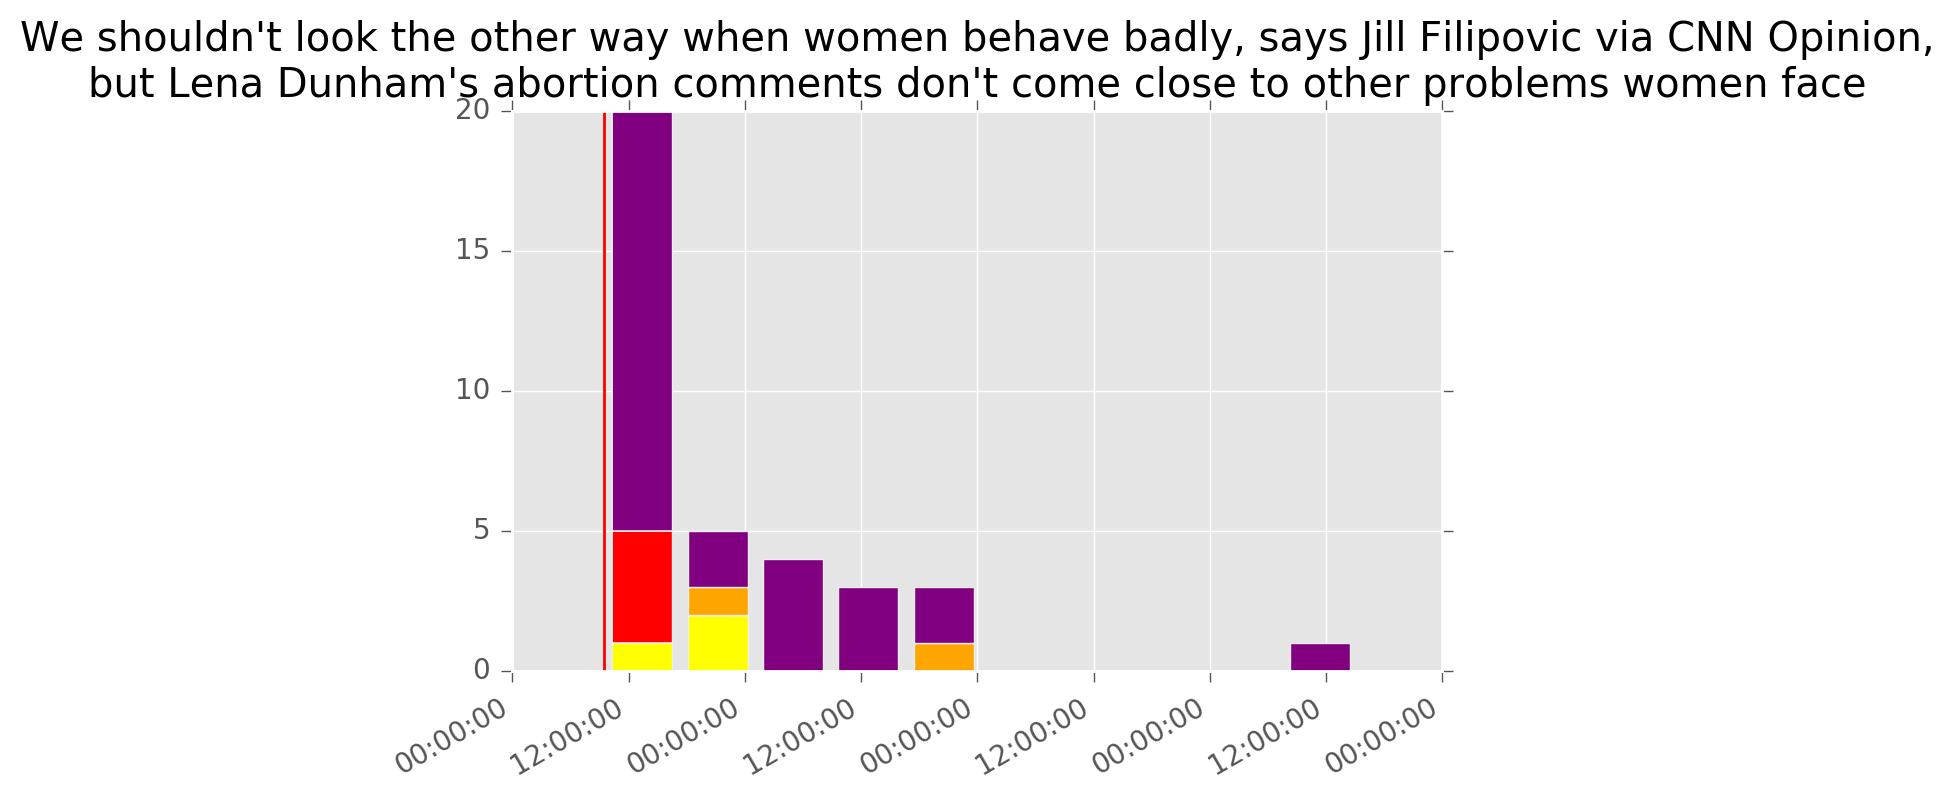

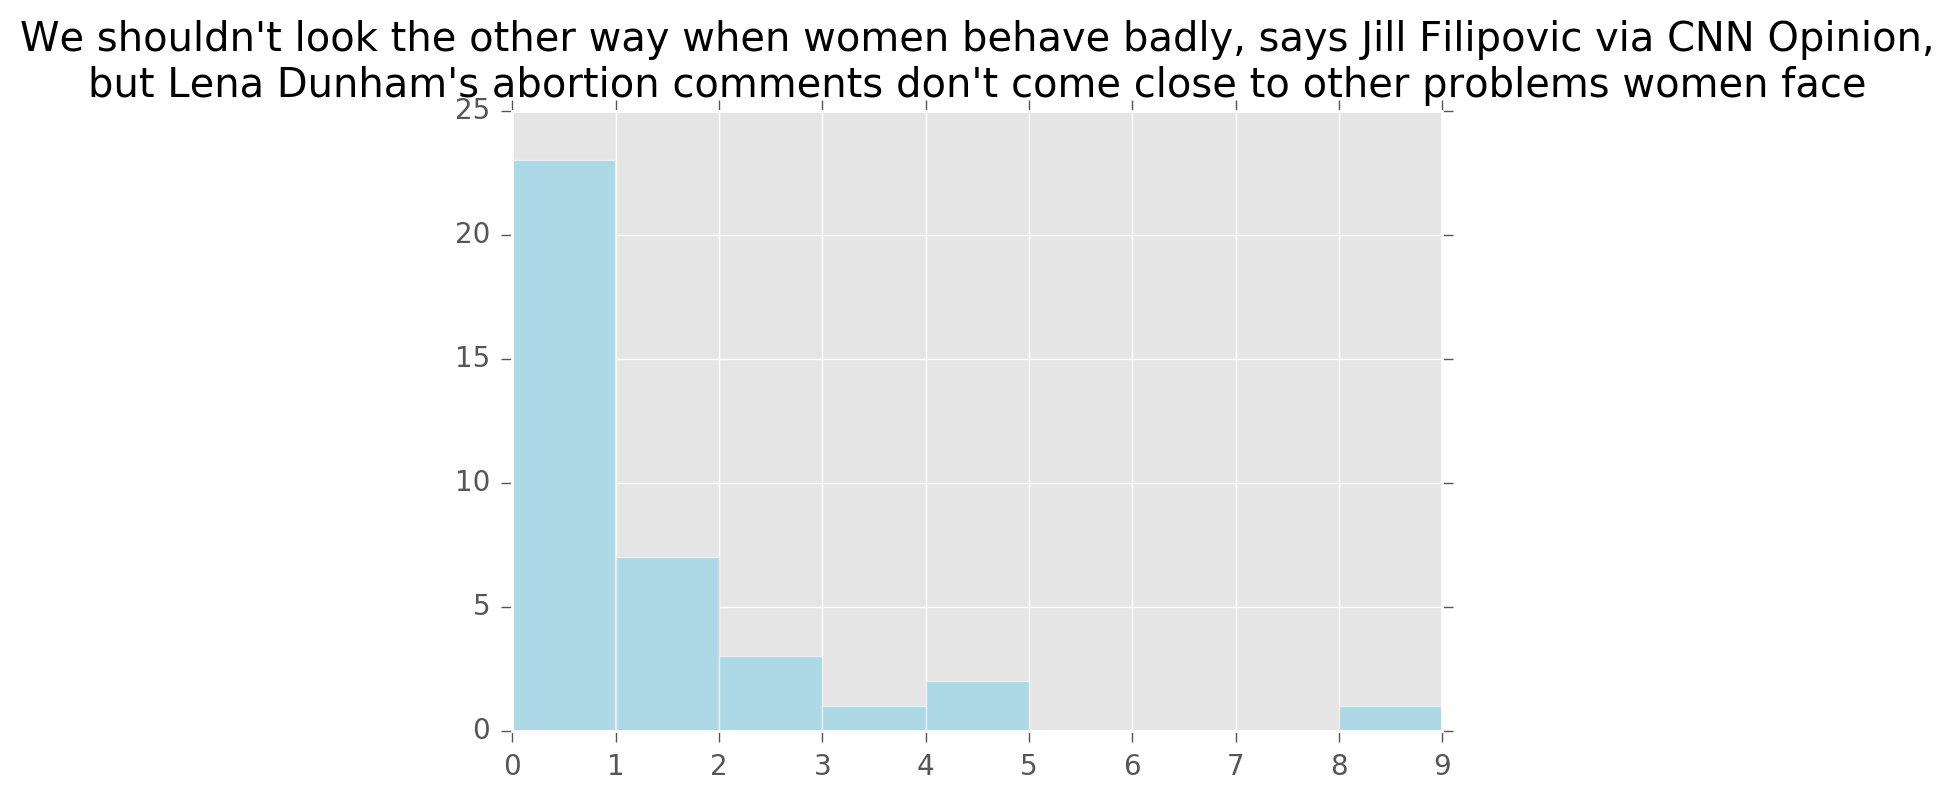

In [190]:
h=fb['comment time']
mes=fb['comment message']

import dateutil.parser as dateparser
import matplotlib

pm=fb['post message']
pm=pm[1]
pm=pm.replace('Opinion, ','Opinion,\n',1)

pt=fb['post time']
pt=pt[1]

likes=fb['comment likes']


t=[]

for item in h:
    t.append(dateparser.parse(item))
    #t.append(time.mktime(date.timetuple()))

val=[]
for i,item in enumerate(mes):
    val.append(i%2)

dates = matplotlib.dates.date2num(t)
#matplotlib.pyplot.plot_date(dates, val)

#matplotlib.pyplot.hist(dates,bins=100)


fig, ax = plt.subplots(1,1)
ax.hist(dates, bins=10, color='lightblue')

matplotlib.pyplot.axvline(x=matplotlib.dates.date2num(dateparser.parse(pt)),color='red')

locator = matplotlib.dates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(matplotlib.dates.AutoDateFormatter(locator))
fig.autofmt_xdate()
plt.show()

val0=[]
val1=[]
val2=[]
val3=[]
val4=[]
val5=[]
for i in range(1,len(pred)):
    if pred[i]=='0':
        val0.append(t[i])
    if pred[i]=='1':
        val1.append(t[i])
    if pred[i]=='2':
        val2.append(t[i])
    if pred[i]=='3':
        val3.append(t[i])
    if pred[i]=='4':
        val4.append(t[i])
    if pred[i]=='5':
        val5.append(t[i])

            
        

fig, ax = plt.subplots(1,1)
ax.hist([matplotlib.dates.date2num(val0),matplotlib.dates.date2num(val1),matplotlib.dates.date2num(val2),matplotlib.dates.date2num(val3),matplotlib.dates.date2num(val4),matplotlib.dates.date2num(val5)],color=['lightblue','yellow','green','red','orange','purple'], bins=10,histtype='barstacked')

matplotlib.pyplot.axvline(x=matplotlib.dates.date2num(dateparser.parse(pt)),color='red')

locator = matplotlib.dates.AutoDateLocator()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(matplotlib.dates.AutoDateFormatter(locator))
fig.autofmt_xdate()
matplotlib.pyplot.title(pm)
plt.show()

likes0=[]
likes1=[]
for i in range(1,len(val)):
    if val[i]==0:
        likes0.append(likes[i])
    else:
        likes1.append(likes[i])
        
        
fig, ax = plt.subplots(1,1)
ax.hist(likes, bins=max(likes),range=(0,max(likes)),color='lightblue',histtype='barstacked')

matplotlib.pyplot.title(pm)
plt.show()
